# Кваліфікаційна робота Антон Смовженко


## Застосування нейронних мереж для виявлення та аналізу захворювань на цукровий діабет


In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from scipy.stats import pearsonr

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from imblearn.under_sampling import NearMiss

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType


In [79]:
from sklearn.metrics import roc_curve

In [2]:
from ucimlrepo import fetch_ucirepo 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

In [3]:
data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [5]:
data.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


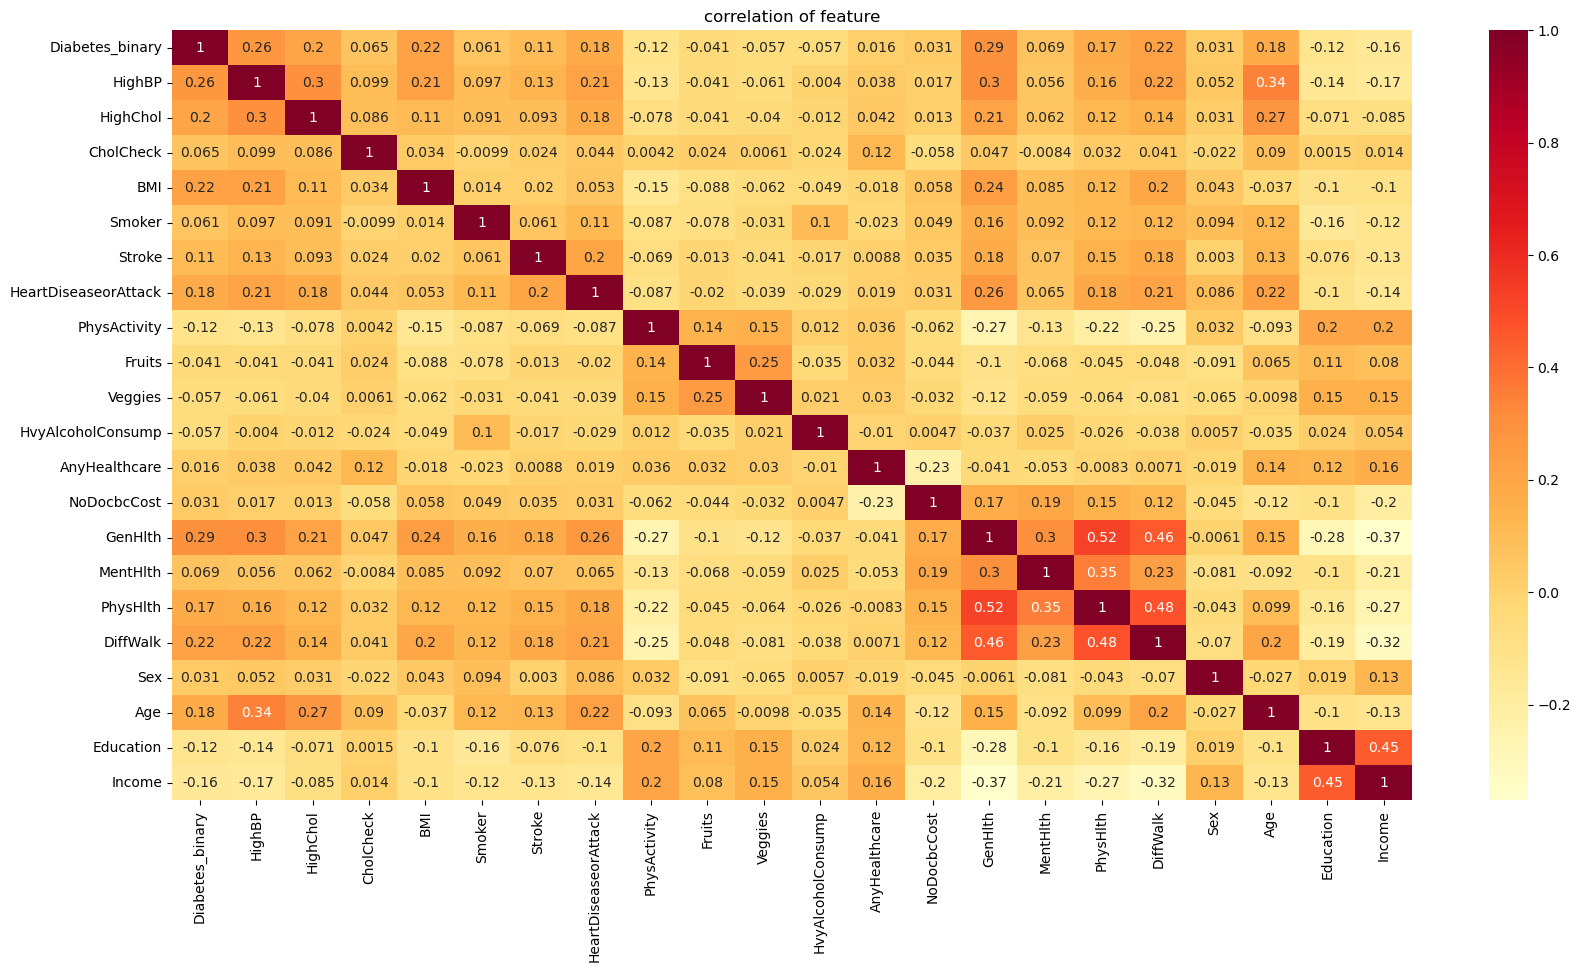

In [6]:
plt.figure(figsize = (20,10))
sns.heatmap(data.corr(),annot=True , cmap ='YlOrRd' )
plt.title("correlation of feature")
plt.show()

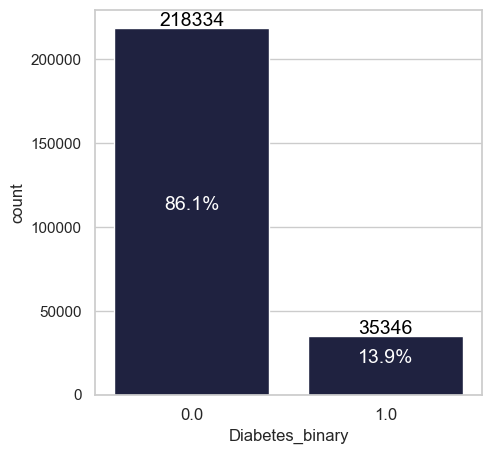

In [7]:
sns.set(style="whitegrid")
total = len(data)
plt.figure(figsize=(5, 5))
ax = sns.countplot(x='Diabetes_binary', data=data, color='#191D46') 
plt.xticks(fontsize=12) 
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=14, color='Black', xytext=(0, 5),
                textcoords='offset points')
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()/2),
                ha='center', va='center', fontsize=14, color='white', xytext=(0, 5),
                textcoords='offset points')
    
plt.show()

In [8]:
diabetic = data[data['Diabetes_binary'] == 1]

In [9]:
healthy = data[data['Diabetes_binary'] == 0]

In [10]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35346 entries, 8 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       35346 non-null  float64
 1   HighBP                35346 non-null  float64
 2   HighChol              35346 non-null  float64
 3   CholCheck             35346 non-null  float64
 4   BMI                   35346 non-null  float64
 5   Smoker                35346 non-null  float64
 6   Stroke                35346 non-null  float64
 7   HeartDiseaseorAttack  35346 non-null  float64
 8   PhysActivity          35346 non-null  float64
 9   Fruits                35346 non-null  float64
 10  Veggies               35346 non-null  float64
 11  HvyAlcoholConsump     35346 non-null  float64
 12  AnyHealthcare         35346 non-null  float64
 13  NoDocbcCost           35346 non-null  float64
 14  GenHlth               35346 non-null  float64
 15  MentHlth              3

In [11]:
healthy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218334 entries, 0 to 253678
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       218334 non-null  float64
 1   HighBP                218334 non-null  float64
 2   HighChol              218334 non-null  float64
 3   CholCheck             218334 non-null  float64
 4   BMI                   218334 non-null  float64
 5   Smoker                218334 non-null  float64
 6   Stroke                218334 non-null  float64
 7   HeartDiseaseorAttack  218334 non-null  float64
 8   PhysActivity          218334 non-null  float64
 9   Fruits                218334 non-null  float64
 10  Veggies               218334 non-null  float64
 11  HvyAlcoholConsump     218334 non-null  float64
 12  AnyHealthcare         218334 non-null  float64
 13  NoDocbcCost           218334 non-null  float64
 14  GenHlth               218334 non-null  float64
 15  MentH

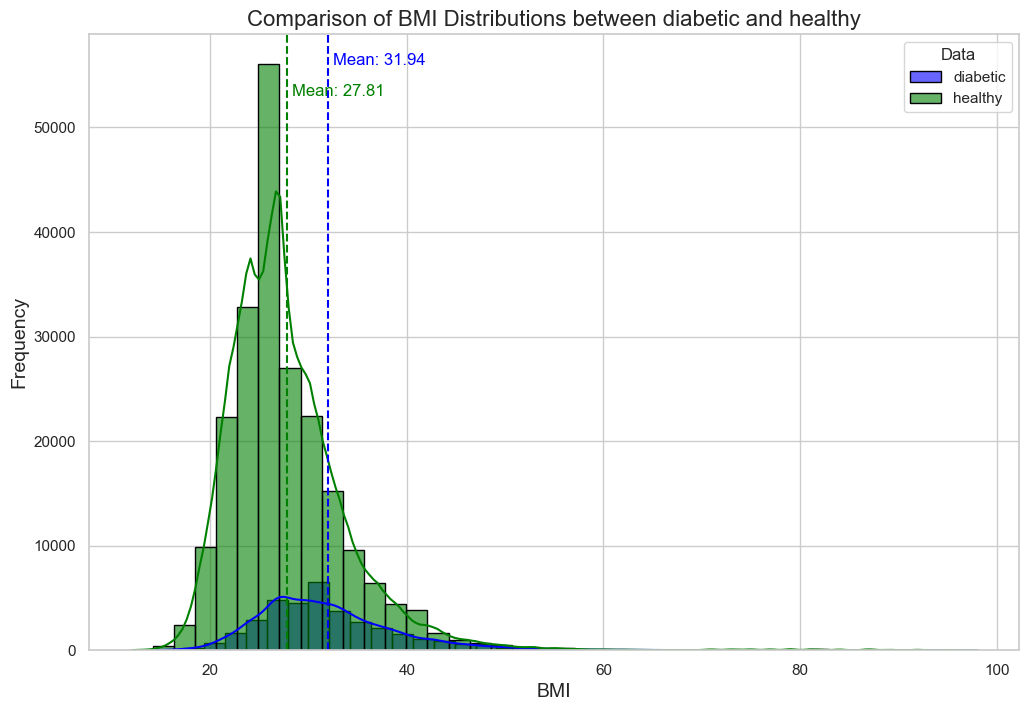

In [12]:
plt.figure(figsize=(12, 8))

sns.histplot(diabetic['BMI'], color='blue', kde=True, label='diabetic', alpha=0.6, bins=40, edgecolor='black')
sns.histplot(healthy['BMI'], color='green', kde=True, label='healthy', alpha=0.6, bins=40, edgecolor='black')

plt.axvline(diabetic['BMI'].mean(), color='blue', linestyle='dashed', linewidth=1.5)
plt.axvline(healthy['BMI'].mean(), color='green', linestyle='dashed', linewidth=1.5)

plt.text(diabetic['BMI'].mean() + 0.5, plt.ylim()[1] * 0.95, 'Mean: {:.2f}'.format(diabetic['BMI'].mean()), color='blue')
plt.text(healthy['BMI'].mean() + 0.5, plt.ylim()[1] * 0.90, 'Mean: {:.2f}'.format(healthy['BMI'].mean()), color='green')

plt.title('Comparison of BMI Distributions between diabetic and healthy', fontsize=16)
plt.xlabel('BMI', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.legend(title='Data')

plt.show()

In [13]:
data['BMI'].max()

98.0

In [14]:
data['BMI'].min()

12.0

C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\3594398983.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetic['BMI Category'] = pd.cut(diabetic['BMI'], bins=bins, labels=labels, right=False)
C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\3594398983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy['BMI Category'] = pd.cut(healthy['BMI'], bins=bins, labels=labels, right=False)


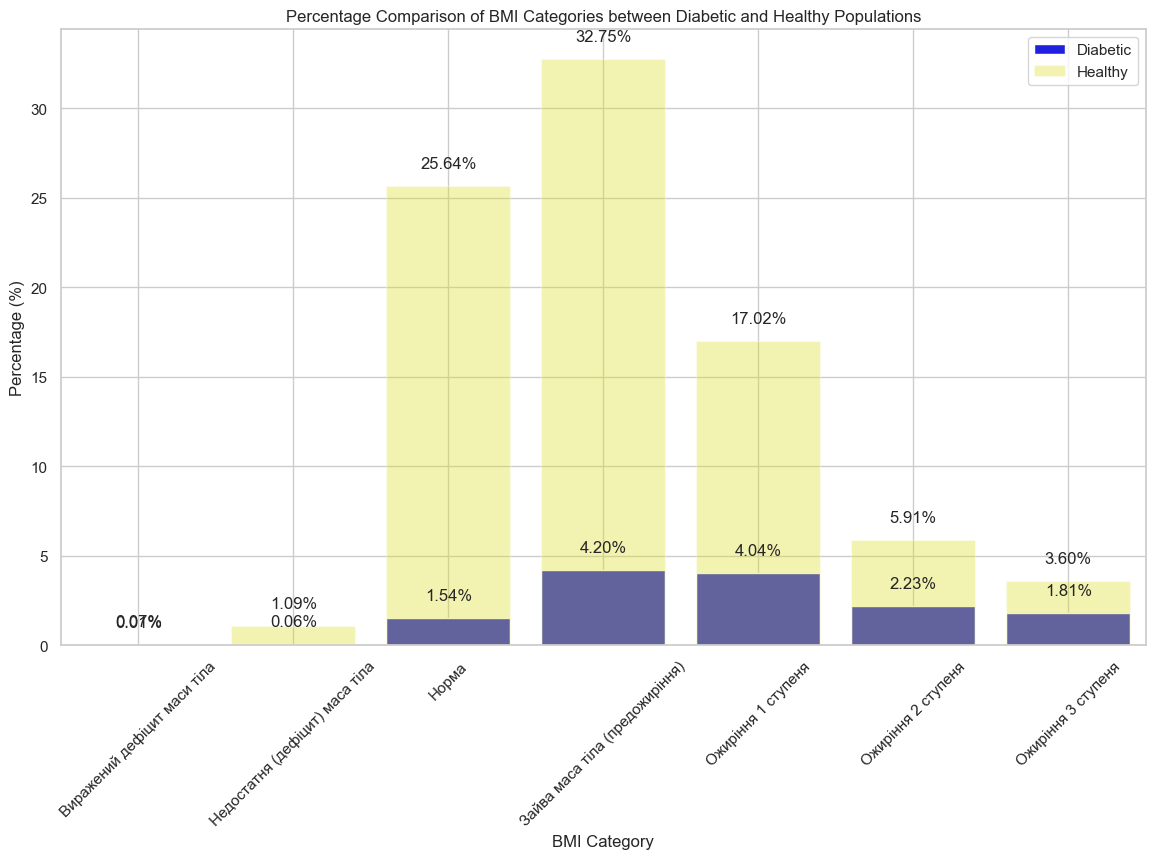

In [15]:
bins = [0, 16, 18.5, 25, 30, 35, 40, float('inf')]
labels = ['Виражений дефіцит маси тіла', 'Недостатня (дефіцит) маса тіла', 'Норма', 'Зайва маса тіла (предожиріння)', 
          'Ожиріння 1 ступеня', 'Ожиріння 2 ступеня', 'Ожиріння 3 ступеня']

diabetic['BMI Category'] = pd.cut(diabetic['BMI'], bins=bins, labels=labels, right=False)
healthy['BMI Category'] = pd.cut(healthy['BMI'], bins=bins, labels=labels, right=False)

bmi_counts_d = diabetic['BMI Category'].value_counts(normalize=True).reindex(labels) * 13.9
bmi_counts_h = healthy['BMI Category'].value_counts(normalize=True).reindex(labels) * 86.1

plt.figure(figsize=(14, 8))
bar1 = sns.barplot(x=bmi_counts_d.index, y=bmi_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=bmi_counts_h.index, y=bmi_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 1, '{:1.2f}%'.format(height), ha="center") 

plt.xticks(rotation=45)
plt.title('Percentage Comparison of BMI Categories between Diabetic and Healthy Populations')
plt.xlabel('BMI Category')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
check = diabetic[(diabetic['BMI'] >= 25) & (diabetic['BMI'] < 30)]
per = len(check)/len(data)
per
#delete this

0.04214758751182592

C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\4196283841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetic['HighChol Category'] = pd.cut(diabetic['HighBP'], bins=bins,  right=False)
C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\4196283841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy['HighChol Category'] = pd.cut(healthy['HighBP'], bins=bins,  right=False)


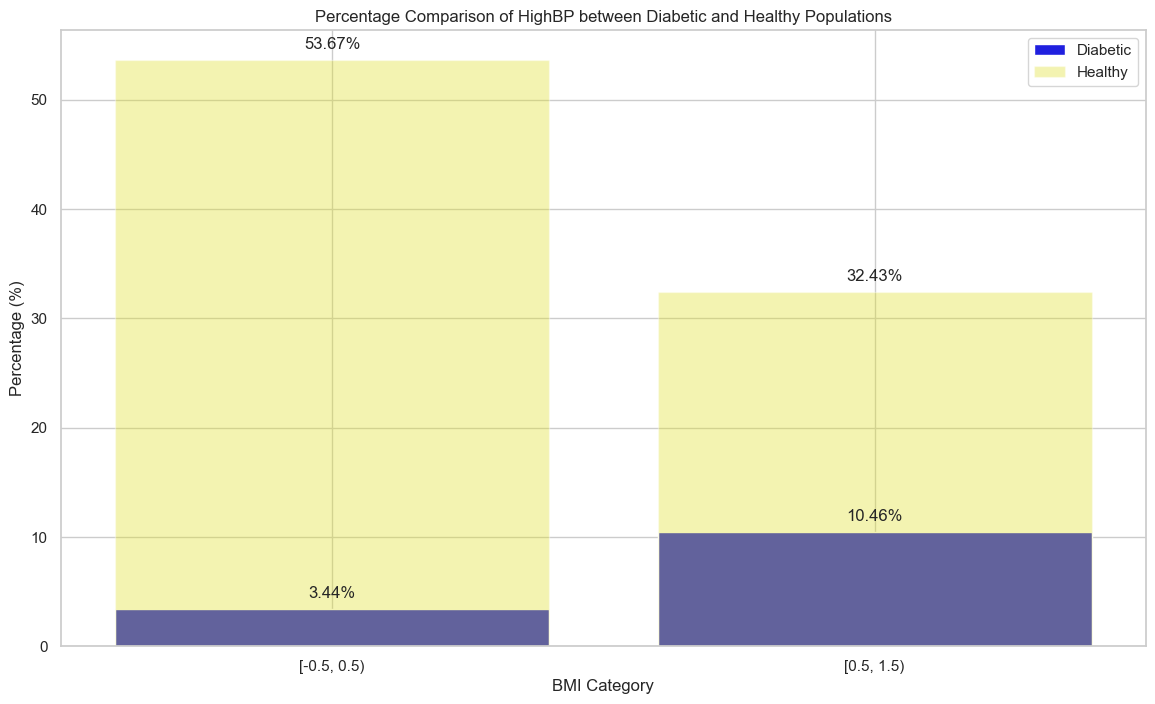

In [17]:
bins = [-0.5, 0.5, 1.5]

diabetic['HighChol Category'] = pd.cut(diabetic['HighBP'], bins=bins,  right=False)
healthy['HighChol Category'] = pd.cut(healthy['HighBP'], bins=bins,  right=False)

HighChol_counts_d = diabetic['HighChol Category'].value_counts(normalize=True) * 13.9
HighChol_counts_h = healthy['HighChol Category'].value_counts(normalize=True) * 86.1

plt.figure(figsize=(14, 8))
bar1 = sns.barplot(x=HighChol_counts_d.index, y=HighChol_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=HighChol_counts_h.index, y=HighChol_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 1, '{:1.2f}%'.format(height), ha="center") 

plt.title('Percentage Comparison of HighBP between Diabetic and Healthy Populations')
plt.xlabel('BMI Category')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\1068329491.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetic['HighChol Category'] = pd.cut(diabetic['HighChol'], bins=bins,  right=False)
C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\1068329491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy['HighChol Category'] = pd.cut(healthy['HighChol'], bins=bins,  right=False)


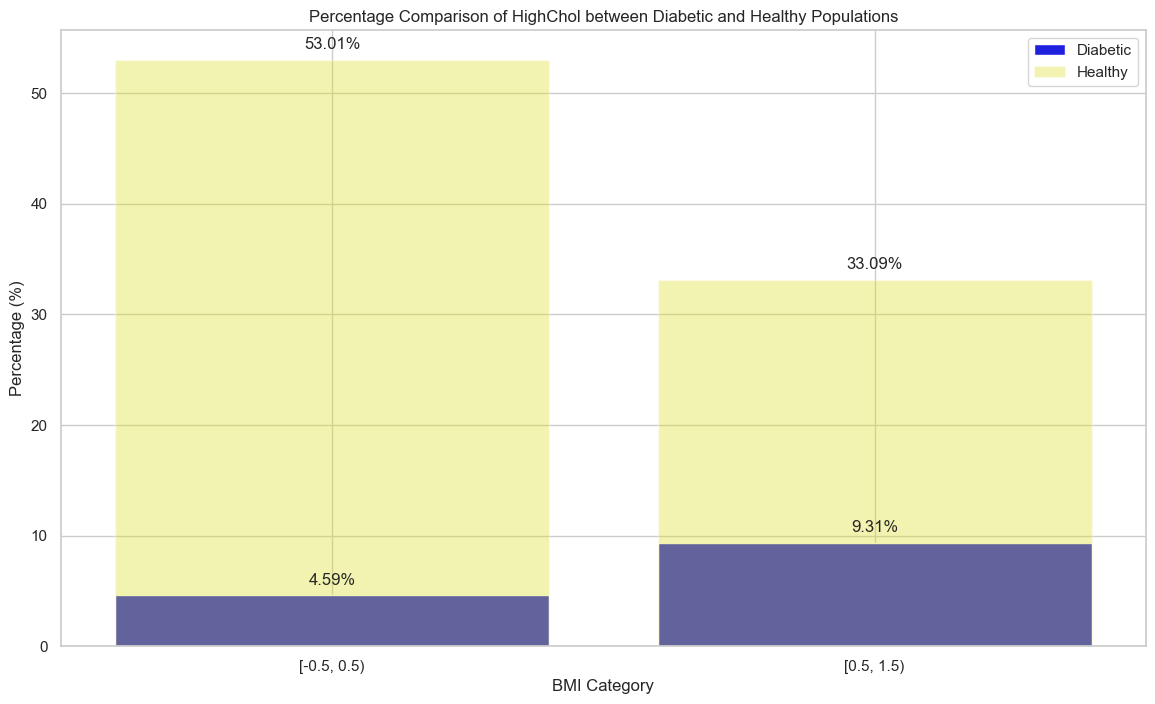

In [18]:
bins = [-0.5, 0.5, 1.5]

diabetic['HighChol Category'] = pd.cut(diabetic['HighChol'], bins=bins,  right=False)
healthy['HighChol Category'] = pd.cut(healthy['HighChol'], bins=bins,  right=False)

HighChol_counts_d = diabetic['HighChol Category'].value_counts(normalize=True) * 13.9
HighChol_counts_h = healthy['HighChol Category'].value_counts(normalize=True) * 86.1

plt.figure(figsize=(14, 8))
bar1 = sns.barplot(x=HighChol_counts_d.index, y=HighChol_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=HighChol_counts_h.index, y=HighChol_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 1, '{:1.2f}%'.format(height), ha="center") 

plt.title('Percentage Comparison of HighChol between Diabetic and Healthy Populations')
plt.xlabel('BMI Category')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\3217013766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetic['HighChol Category'] = pd.cut(diabetic['CholCheck'], bins=bins,  right=False)
C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\3217013766.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy['HighChol Category'] = pd.cut(healthy['CholCheck'], bins=bins,  right=False)


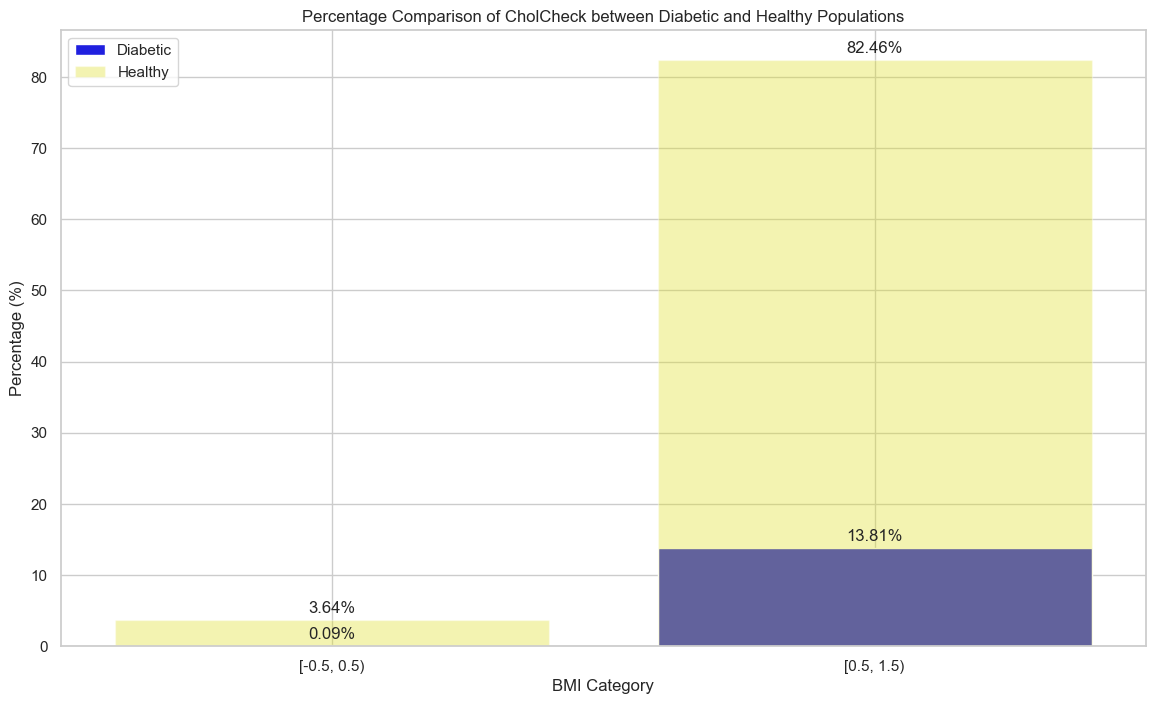

In [19]:

bins = [-0.5, 0.5, 1.5]

diabetic['HighChol Category'] = pd.cut(diabetic['CholCheck'], bins=bins,  right=False)
healthy['HighChol Category'] = pd.cut(healthy['CholCheck'], bins=bins,  right=False)

HighChol_counts_d = diabetic['HighChol Category'].value_counts(normalize=True) * 13.9
HighChol_counts_h = healthy['HighChol Category'].value_counts(normalize=True) * 86.1

plt.figure(figsize=(14, 8))
bar1 = sns.barplot(x=HighChol_counts_d.index, y=HighChol_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=HighChol_counts_h.index, y=HighChol_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 1, '{:1.2f}%'.format(height), ha="center") 

plt.title('Percentage Comparison of CholCheck between Diabetic and Healthy Populations')
plt.xlabel('BMI Category')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\462052516.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetic['HighChol Category'] = pd.cut(diabetic['Sex'], bins=bins,  right=False)
C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\462052516.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy['HighChol Category'] = pd.cut(healthy['Sex'], bins=bins,  right=False)


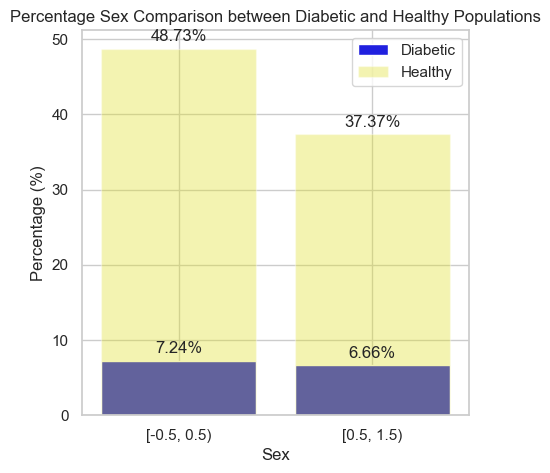

In [20]:
bins = [-0.5, 0.5, 1.5]

diabetic['HighChol Category'] = pd.cut(diabetic['Sex'], bins=bins,  right=False)
healthy['HighChol Category'] = pd.cut(healthy['Sex'], bins=bins,  right=False)


HighChol_counts_d = diabetic['HighChol Category'].value_counts(normalize=True) * 13.9
HighChol_counts_h = healthy['HighChol Category'].value_counts(normalize=True) * 86.1


plt.figure(figsize=(5, 5))
bar1 = sns.barplot(x=HighChol_counts_d.index, y=HighChol_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=HighChol_counts_h.index, y=HighChol_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 1, '{:1.2f}%'.format(height), ha="center") 

#plt.xticks(rotation=45)
plt.title('Percentage Sex Comparison between Diabetic and Healthy Populations')
plt.xlabel('Sex')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\3670905517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetic['HighChol Category'] = pd.cut(diabetic['DiffWalk'], bins=bins,  right=False)
C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\3670905517.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy['HighChol Category'] = pd.cut(healthy['DiffWalk'], bins=bins,  right=False)


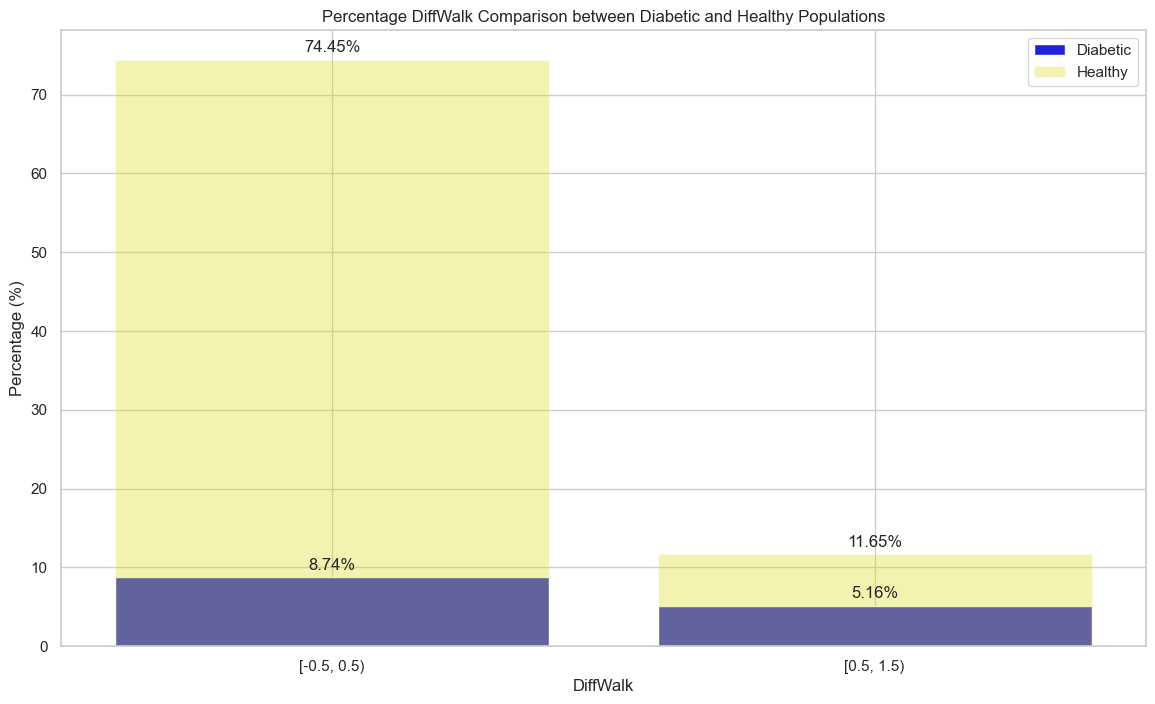

In [21]:
bins = [-0.5, 0.5, 1.5]

diabetic['HighChol Category'] = pd.cut(diabetic['DiffWalk'], bins=bins,  right=False)
healthy['HighChol Category'] = pd.cut(healthy['DiffWalk'], bins=bins,  right=False)


HighChol_counts_d = diabetic['HighChol Category'].value_counts(normalize=True) * 13.9
HighChol_counts_h = healthy['HighChol Category'].value_counts(normalize=True) * 86.1


plt.figure(figsize=(14, 8))
bar1 = sns.barplot(x=HighChol_counts_d.index, y=HighChol_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=HighChol_counts_h.index, y=HighChol_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 1, '{:1.2f}%'.format(height), ha="center") 

#plt.xticks(rotation=45)
plt.title('Percentage DiffWalk Comparison between Diabetic and Healthy Populations')
plt.xlabel('DiffWalk')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


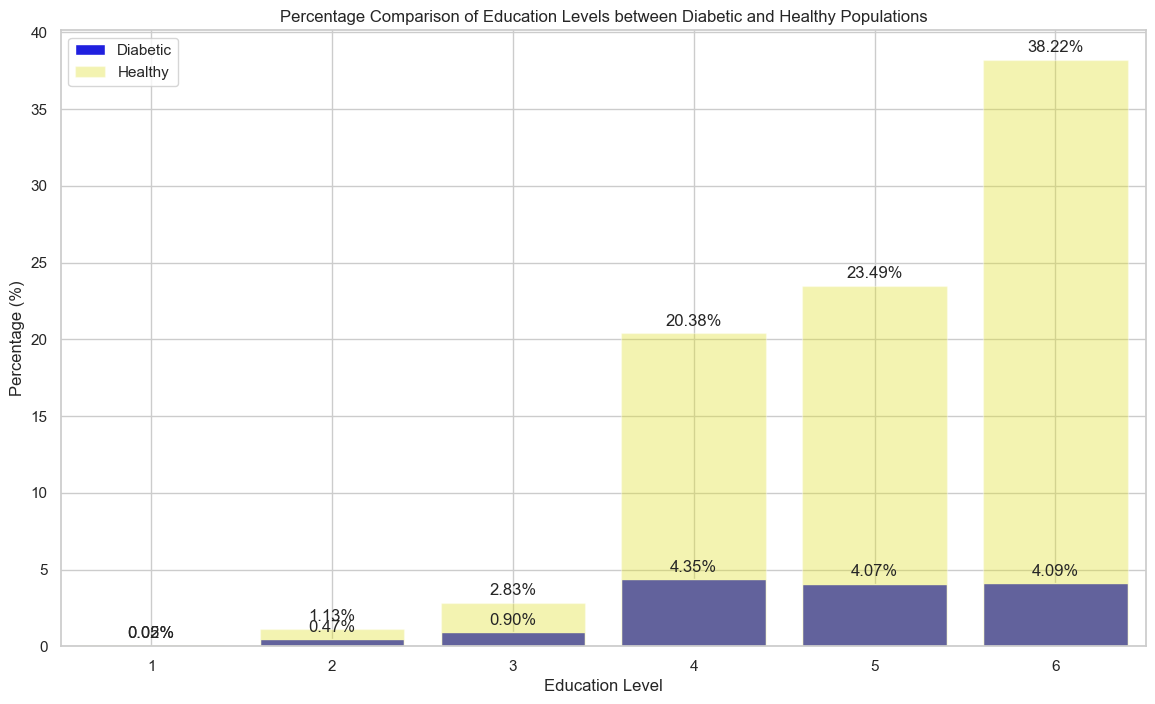

In [22]:
labels = ['1', '2', '3', '4', '5', '6']
values = [1, 2, 3, 4, 5, 6]

education_counts_d = diabetic['Education'].value_counts(normalize=True).reindex(values) * 13.9
education_counts_h = healthy['Education'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(14, 8))
bar1 = sns.barplot(x=labels, y=education_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=education_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage Comparison of Education Levels between Diabetic and Healthy Populations')
plt.xlabel('Education Level')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


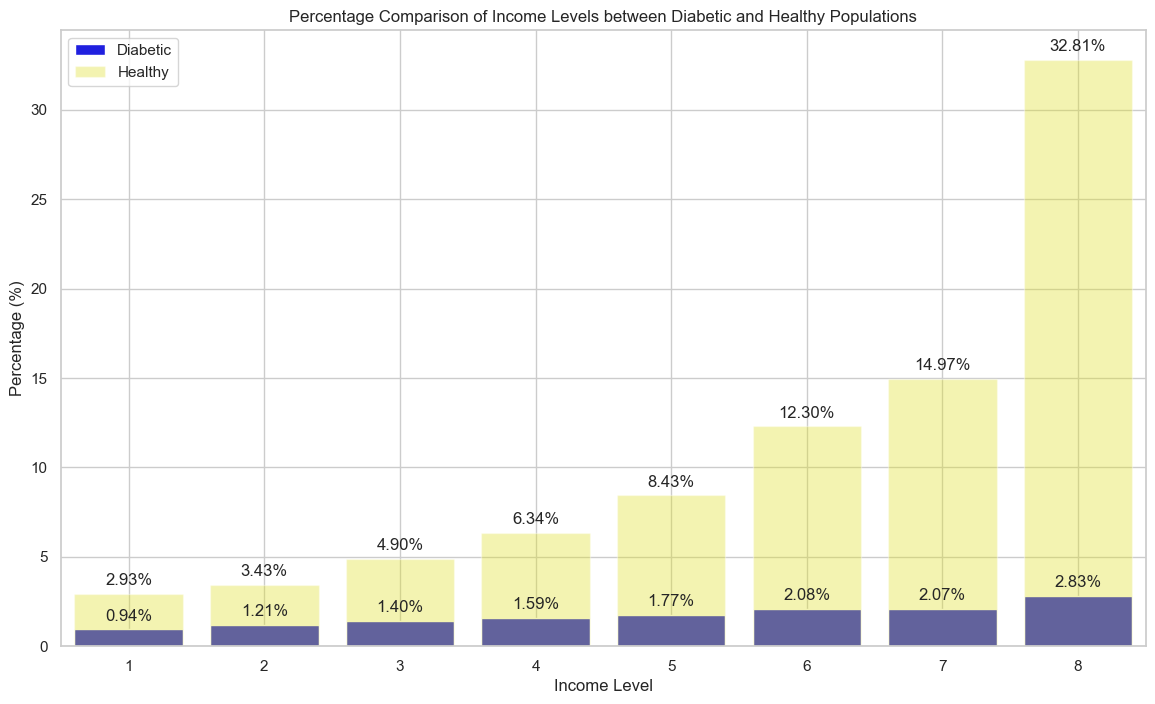

In [23]:
labels = ['1', '2', '3', '4', '5', '6', '7', '8']
values = [1, 2, 3, 4, 5, 6, 7, 8]

income_counts_d = diabetic['Income'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['Income'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(14, 8))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")

plt.title('Percentage Comparison of Income Levels between Diabetic and Healthy Populations')
plt.xlabel('Income Level')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


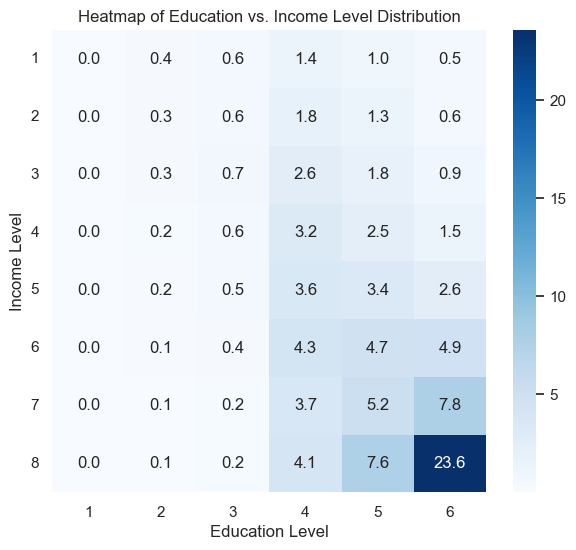

In [24]:
combined_data = pd.concat([diabetic, healthy], axis=0)

combined_data['Income'] = combined_data['Income'].astype(int)
combined_data['Education'] = combined_data['Education'].astype(int)

pivot_table = pd.crosstab(combined_data['Income'], combined_data['Education'], normalize='all') * 100

plt.figure(figsize=(7, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.1f')
plt.title('Heatmap of Education vs. Income Level Distribution')
plt.xlabel('Education Level')
plt.ylabel('Income Level')
plt.yticks(rotation=0)
plt.show()

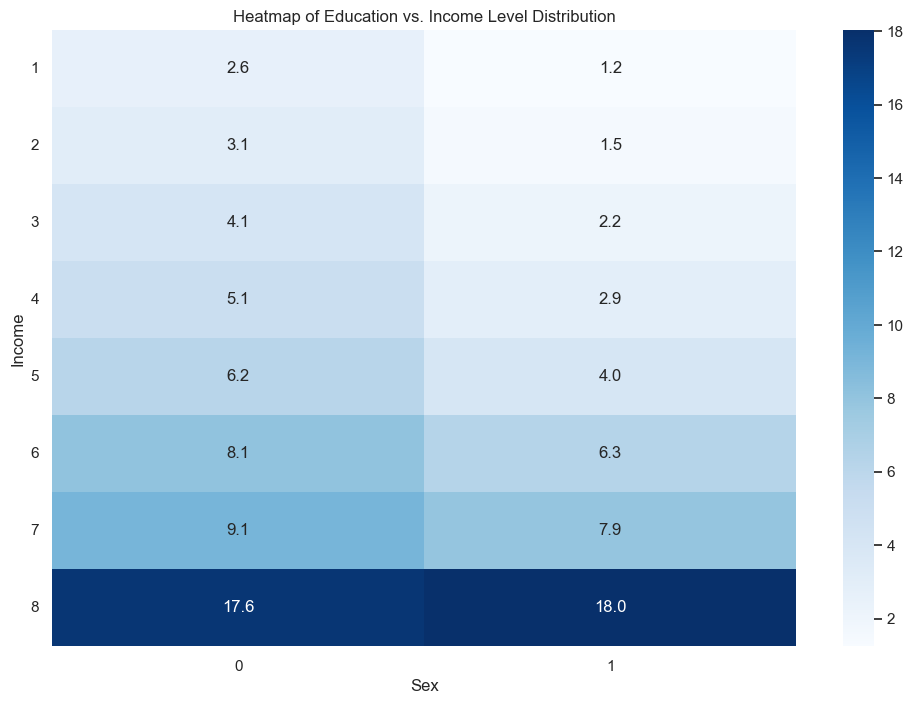

In [25]:
combined_data['Sex'] = data['Sex'].astype(int)

pivot_table = pd.crosstab(combined_data['Income'], combined_data['Sex'], normalize='all') * 100

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.1f')
plt.title('Heatmap of Education vs. Income Level Distribution')

plt.yticks(rotation=0) 
plt.show()

C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\3302282320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetic['HighChol Category'] = pd.cut(diabetic['AnyHealthcare'], bins=bins,  right=False)
C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\3302282320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy['HighChol Category'] = pd.cut(healthy['AnyHealthcare'], bins=bins,  right=False)


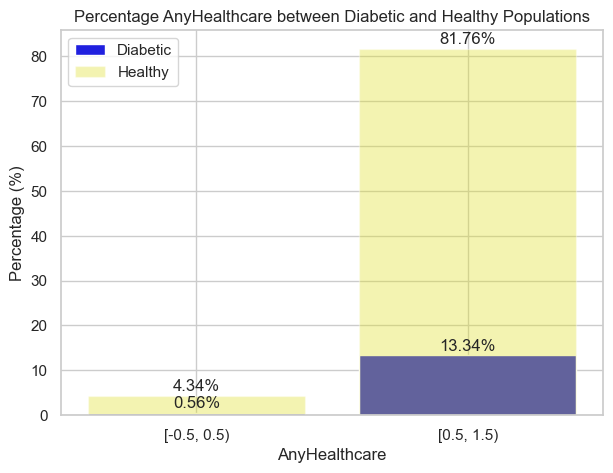

In [26]:
bins = [-0.5, 0.5, 1.5]

diabetic['HighChol Category'] = pd.cut(diabetic['AnyHealthcare'], bins=bins,  right=False)
healthy['HighChol Category'] = pd.cut(healthy['AnyHealthcare'], bins=bins,  right=False)

HighChol_counts_d = diabetic['HighChol Category'].value_counts(normalize=True) * 13.9
HighChol_counts_h = healthy['HighChol Category'].value_counts(normalize=True) * 86.1

plt.figure(figsize=(7, 5))
bar1 = sns.barplot(x=HighChol_counts_d.index, y=HighChol_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=HighChol_counts_h.index, y=HighChol_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 1, '{:1.2f}%'.format(height), ha="center") 

plt.title('Percentage AnyHealthcare between Diabetic and Healthy Populations')
plt.xlabel('AnyHealthcare')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


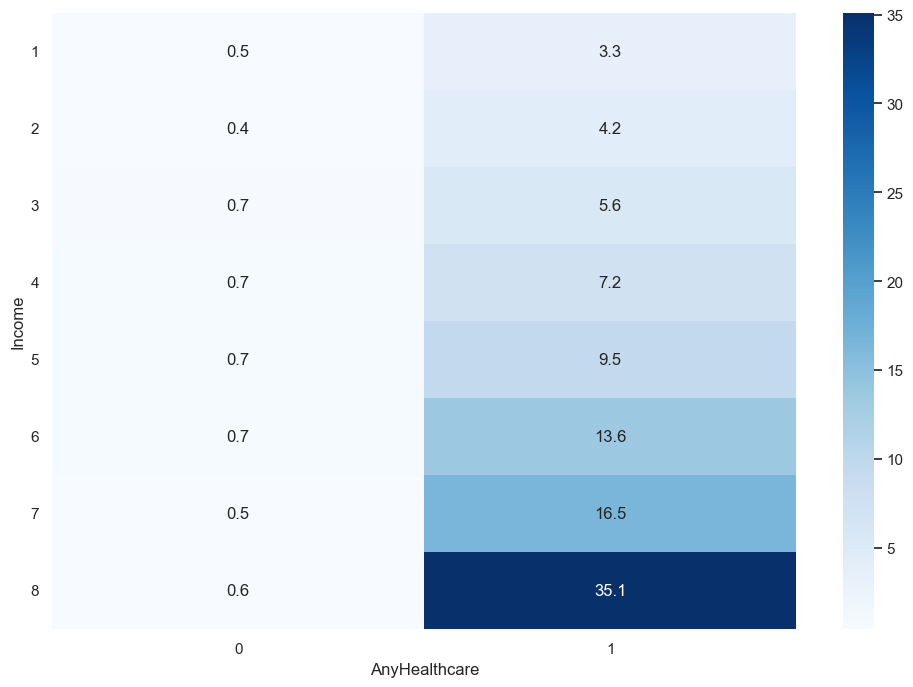

In [27]:
combined_data['AnyHealthcare'] = data['AnyHealthcare'].astype(int)

pivot_table = pd.crosstab(combined_data['Income'], combined_data['AnyHealthcare'], normalize='all') * 100

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.1f')

plt.yticks(rotation=0)  
plt.show()

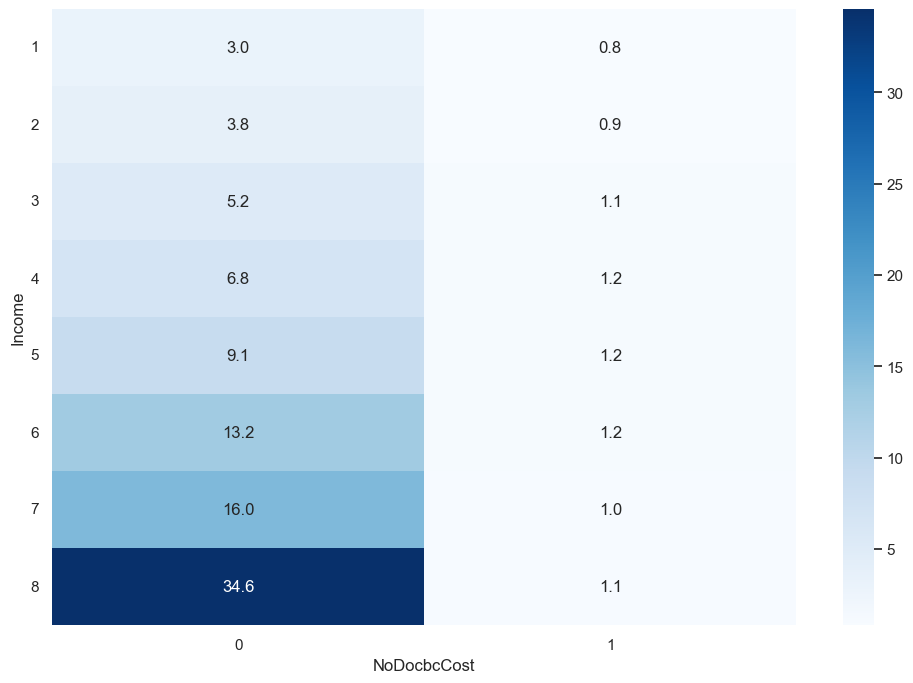

In [28]:
combined_data['NoDocbcCost'] = data['NoDocbcCost'].astype(int)

pivot_table = pd.crosstab(combined_data['Income'], combined_data['NoDocbcCost'], normalize='all') * 100

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.1f')

plt.yticks(rotation=0) 
plt.show()

C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\331751399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetic['HighChol Category'] = pd.cut(diabetic['NoDocbcCost'], bins=bins,  right=False)
C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\331751399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy['HighChol Category'] = pd.cut(healthy['NoDocbcCost'], bins=bins,  right=False)


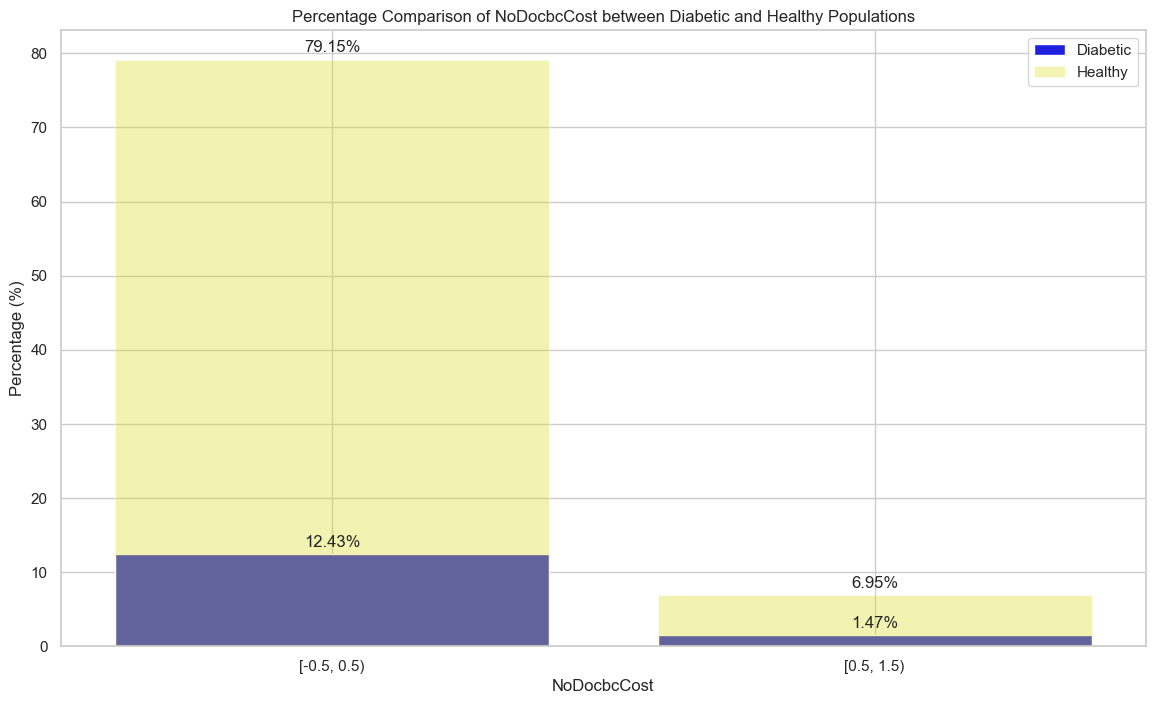

In [29]:
bins = [-0.5, 0.5, 1.5]

diabetic['HighChol Category'] = pd.cut(diabetic['NoDocbcCost'], bins=bins,  right=False)
healthy['HighChol Category'] = pd.cut(healthy['NoDocbcCost'], bins=bins,  right=False)

HighChol_counts_d = diabetic['HighChol Category'].value_counts(normalize=True) * 13.9
HighChol_counts_h = healthy['HighChol Category'].value_counts(normalize=True) * 86.1

plt.figure(figsize=(14, 8))
bar1 = sns.barplot(x=HighChol_counts_d.index, y=HighChol_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=HighChol_counts_h.index, y=HighChol_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 1, '{:1.2f}%'.format(height), ha="center") 

plt.title('Percentage Comparison of NoDocbcCost between Diabetic and Healthy Populations')
plt.xlabel('NoDocbcCost')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
df = data

# Group by the 'Diabetes_binary' and calculate mean for each group
grouped = df.groupby('Diabetes_binary').mean()

# Calculate the percentage difference for each feature
percent_difference = (grouped.loc[1] - grouped.loc[0]) / grouped.loc[0] * 100
percent_difference_sorted = percent_difference.sort_values(ascending=False)

print(percent_difference_sorted)


HeartDiseaseorAttack    203.857620
Stroke                  187.394626
DiffWalk                174.240609
PhysHlth                118.464691
HighBP                   99.859205
HighChol                 74.375305
MentHlth                 49.823899
GenHlth                  37.975900
NoDocbcCost              31.243017
Smoker                   20.231462
Age                      20.027837
BMI                      14.882668
Sex                      10.380113
CholCheck                 3.701648
AnyHealthcare             1.066483
Education                -6.946961
Veggies                  -7.791741
Fruits                   -8.832288
Income                  -15.836908
PhysActivity            -18.843676
HvyAlcoholConsump       -61.715544
dtype: float64


In [31]:
df = data

def categorize_bmi(bmi):
    if bmi <= 16:
        return 'Very Severely Underweight'
    elif bmi <= 18.5:
        return 'Underweight'
    elif bmi <= 25:
        return 'Normal'
    elif bmi <= 30:
        return 'Overweight'
    elif bmi <= 35:
        return 'Obesity Class I'
    elif bmi <= 40:
        return 'Obesity Class II'
    else:
        return 'Obesity Class III'

# Categorizing BMI
df['BMI'] = df['BMI'].apply(categorize_bmi)

category_distributions = {}

for column in df.columns:
    distribution = df[column].value_counts(normalize=True).sort_index() * 100
    category_distributions[column] = distribution

for column, distribution in category_distributions.items():
    print(f"Distribution for {column}:\n{distribution}\n")

Distribution for Diabetes_binary:
Diabetes_binary
0.0    86.066698
1.0    13.933302
Name: proportion, dtype: float64

Distribution for HighBP:
HighBP
0.0    57.09989
1.0    42.90011
Name: proportion, dtype: float64

Distribution for HighChol:
HighChol
0.0    57.587906
1.0    42.412094
Name: proportion, dtype: float64

Distribution for CholCheck:
CholCheck
0.0     3.73305
1.0    96.26695
Name: proportion, dtype: float64

Distribution for BMI:
BMI
Normal                       33.940003
Obesity Class I              17.523258
Obesity Class II              6.837748
Obesity Class III             4.524992
Overweight                   35.941343
Underweight                   1.016635
Very Severely Underweight     0.216020
Name: proportion, dtype: float64

Distribution for Smoker:
Smoker
0.0    55.683144
1.0    44.316856
Name: proportion, dtype: float64

Distribution for Stroke:
Stroke
0.0    95.94292
1.0     4.05708
Name: proportion, dtype: float64

Distribution for HeartDiseaseorAttack:
HeartD

In [32]:
df = healthy

def categorize_bmi(bmi):
    if bmi <= 16:
        return 'Very Severely Underweight'
    elif bmi <= 18.5:
        return 'Underweight'
    elif bmi <= 25:
        return 'Normal'
    elif bmi <= 30:
        return 'Overweight'
    elif bmi <= 35:
        return 'Obesity Class I'
    elif bmi <= 40:
        return 'Obesity Class II'
    else:
        return 'Obesity Class III'

df['BMI'] = df['BMI'].apply(categorize_bmi)

category_distributions = {}

for column in df.columns:
    distribution = df[column].value_counts(normalize=True).sort_index() * 100
    category_distributions[column] = distribution

for column, distribution in category_distributions.items():
    print(f"Distribution for {column}:\n{distribution}\n")

Distribution for Diabetes_binary:
Diabetes_binary
0.0    100.0
Name: proportion, dtype: float64

Distribution for HighBP:
HighBP
0.0    62.33981
1.0    37.66019
Name: proportion, dtype: float64

Distribution for HighChol:
HighChol
0.0    61.570346
1.0    38.429654
Name: proportion, dtype: float64

Distribution for CholCheck:
CholCheck
0.0     4.22701
1.0    95.77299
Name: proportion, dtype: float64

Distribution for BMI:
BMI
Normal                       36.970879
Obesity Class I              16.053386
Obesity Class II              5.677998
Obesity Class III             3.479073
Overweight                   36.463858
Underweight                   1.121218
Very Severely Underweight     0.233587
Name: proportion, dtype: float64

Distribution for Smoker:
Smoker
0.0    56.898147
1.0    43.101853
Name: proportion, dtype: float64

Distribution for Stroke:
Stroke
0.0    96.782911
1.0     3.217089
Name: proportion, dtype: float64

Distribution for HeartDiseaseorAttack:
HeartDiseaseorAttack
0.0 

C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\751631799.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BMI'] = df['BMI'].apply(categorize_bmi)


In [33]:
df = diabetic

def categorize_bmi(bmi):
    if bmi <= 16:
        return 'Very Severely Underweight'
    elif bmi <= 18.5:
        return 'Underweight'
    elif bmi <= 25:
        return 'Normal'
    elif bmi <= 30:
        return 'Overweight'
    elif bmi <= 35:
        return 'Obesity Class I'
    elif bmi <= 40:
        return 'Obesity Class II'
    else:
        return 'Obesity Class III'

df['BMI'] = df['BMI'].apply(categorize_bmi)

category_distributions = {}

for column in df.columns:
    distribution = df[column].value_counts(normalize=True).sort_index() * 100
    category_distributions[column] = distribution

for column, distribution in category_distributions.items():
    print(f"Distribution for {column}:\n{distribution}\n")

Distribution for Diabetes_binary:
Diabetes_binary
1.0    100.0
Name: proportion, dtype: float64

Distribution for HighBP:
HighBP
0.0    24.732643
1.0    75.267357
Name: proportion, dtype: float64

Distribution for HighChol:
HighChol
0.0    32.988174
1.0    67.011826
Name: proportion, dtype: float64

Distribution for CholCheck:
CholCheck
0.0     0.681831
1.0    99.318169
Name: proportion, dtype: float64

Distribution for BMI:
BMI
Normal                       15.218129
Obesity Class I              26.602727
Obesity Class II             14.001584
Obesity Class III            10.985684
Overweight                   32.713744
Underweight                   0.370622
Very Severely Underweight     0.107509
Name: proportion, dtype: float64

Distribution for Smoker:
Smoker
0.0    48.178012
1.0    51.821988
Name: proportion, dtype: float64

Distribution for Stroke:
Stroke
0.0    90.754258
1.0     9.245742
Name: proportion, dtype: float64

Distribution for HeartDiseaseorAttack:
HeartDiseaseorAttack


C:\Users\smovs\AppData\Local\Temp\ipykernel_23112\4076871253.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BMI'] = df['BMI'].apply(categorize_bmi)


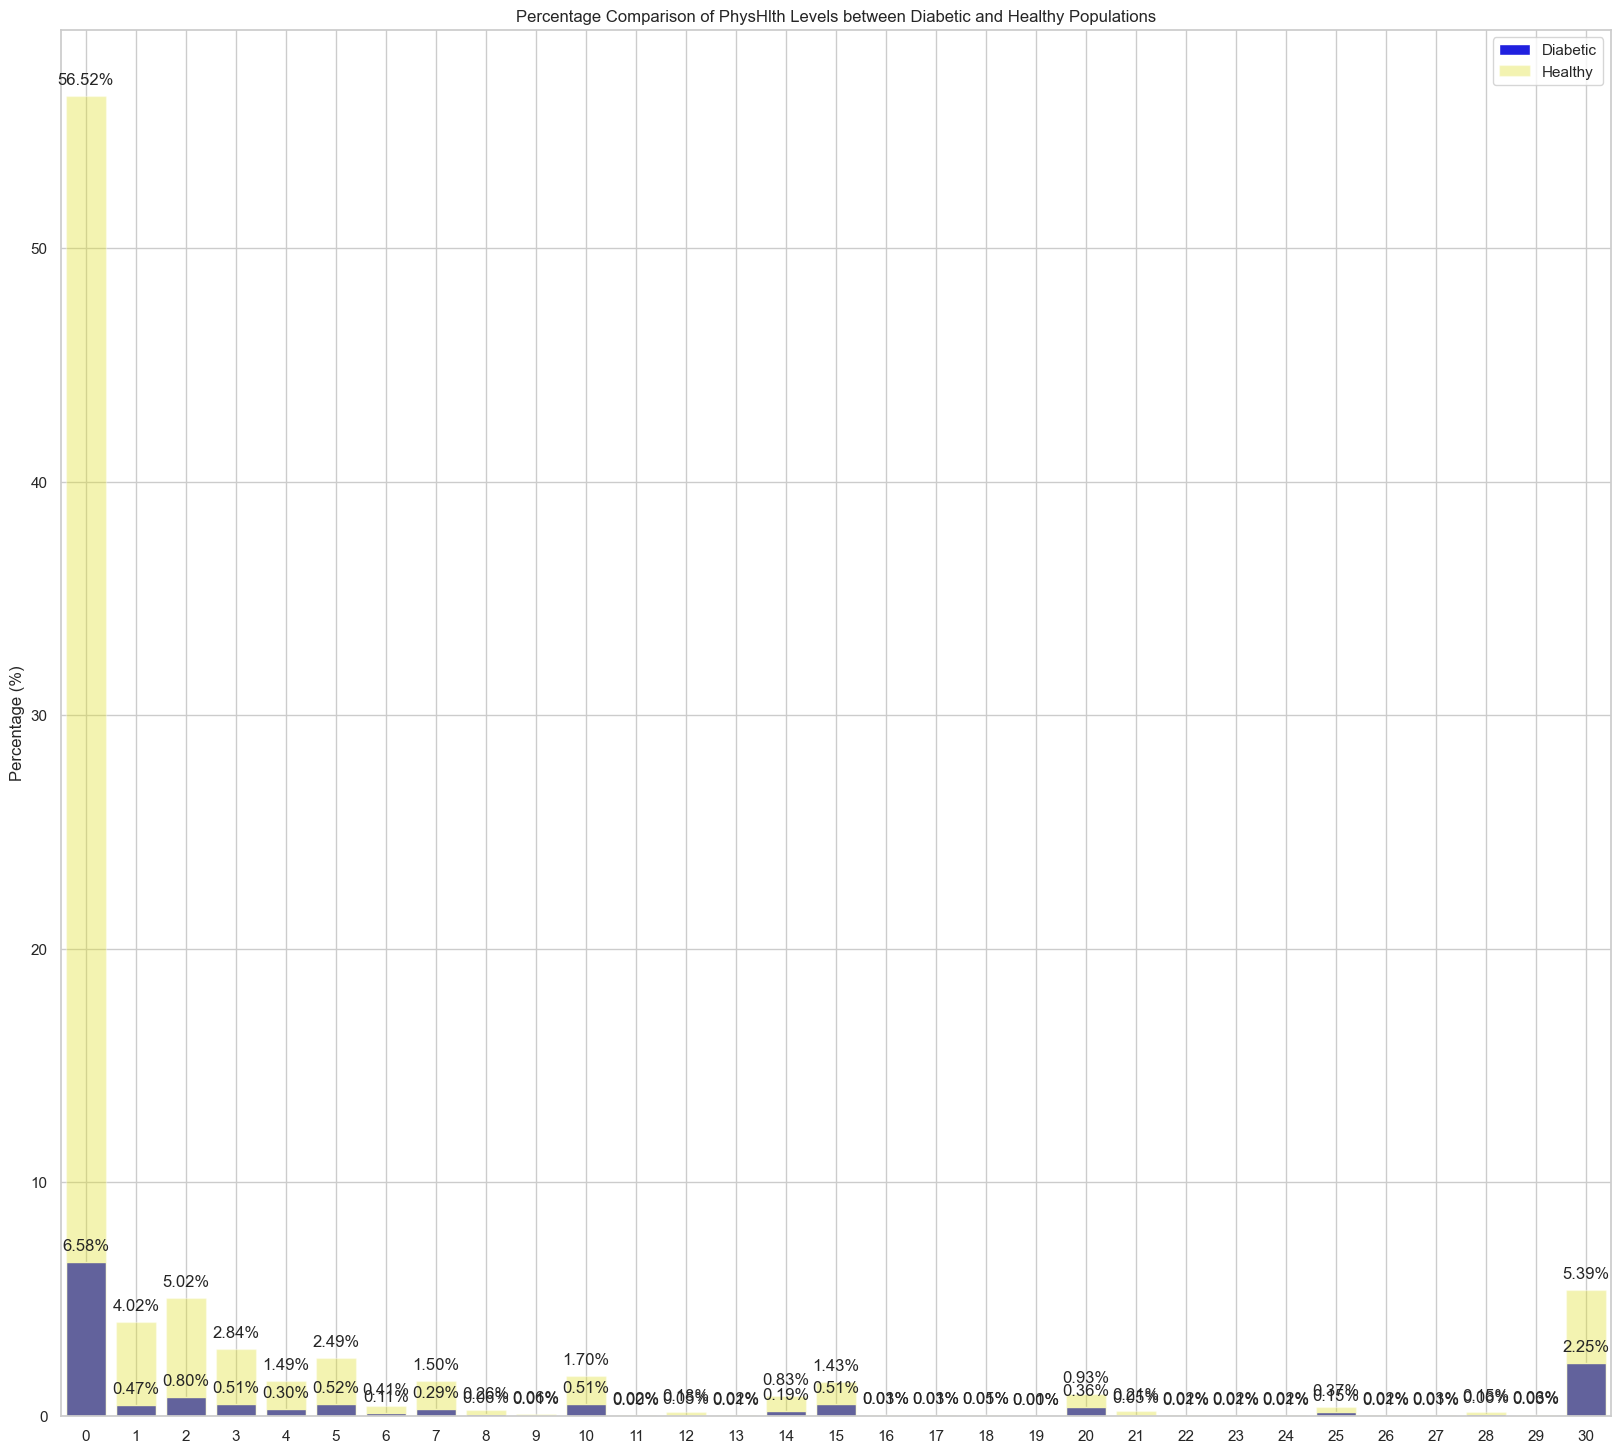

In [34]:
labels = [str(i) for i in range(31)]
values = list(range(31))

income_counts_d = diabetic['PhysHlth'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['PhysHlth'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(20, 18))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage Comparison of PhysHlth Levels between Diabetic and Healthy Populations')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


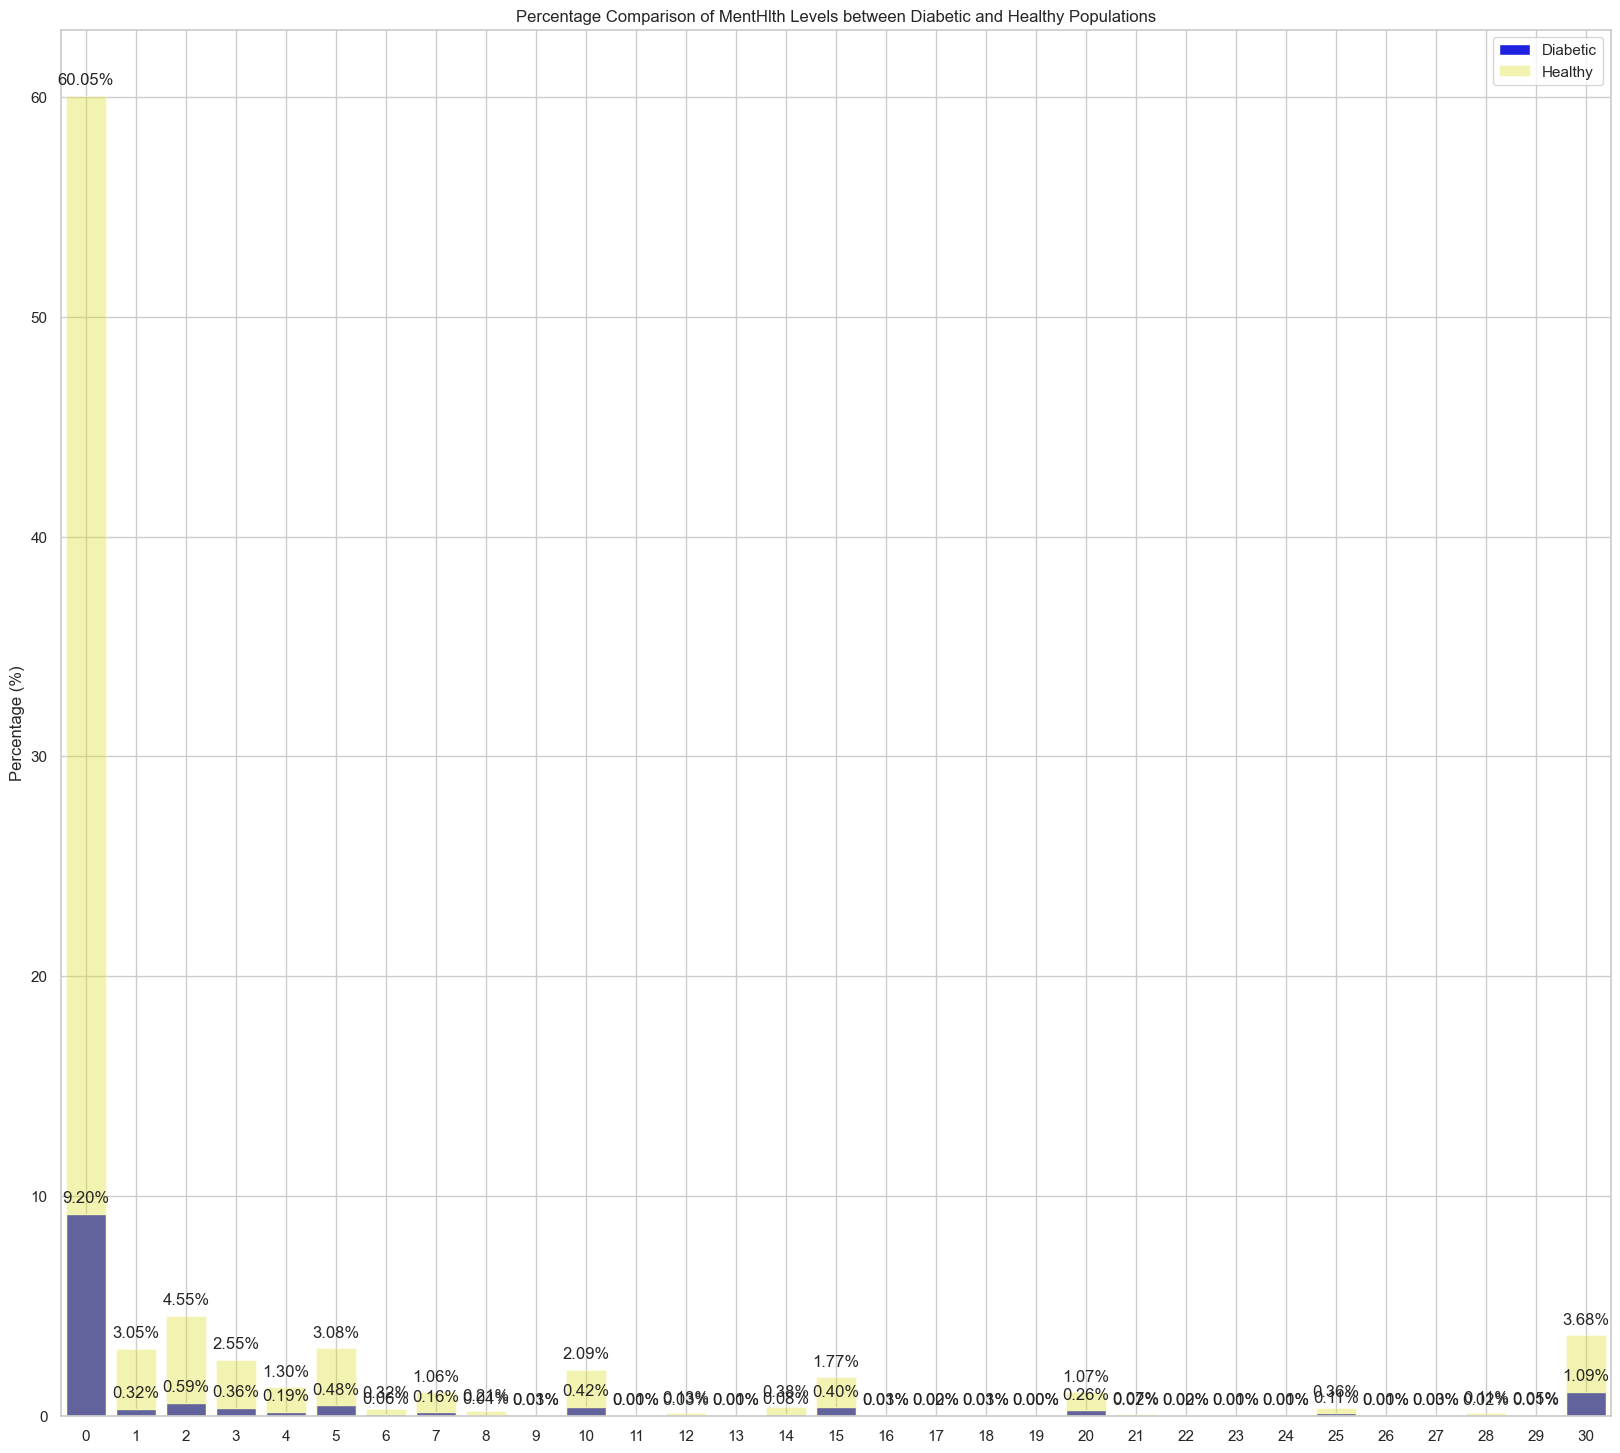

In [35]:
labels = [str(i) for i in range(31)]
values = list(range(31))

income_counts_d = diabetic['MentHlth'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['MentHlth'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(20, 18))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage Comparison of MentHlth Levels between Diabetic and Healthy Populations')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


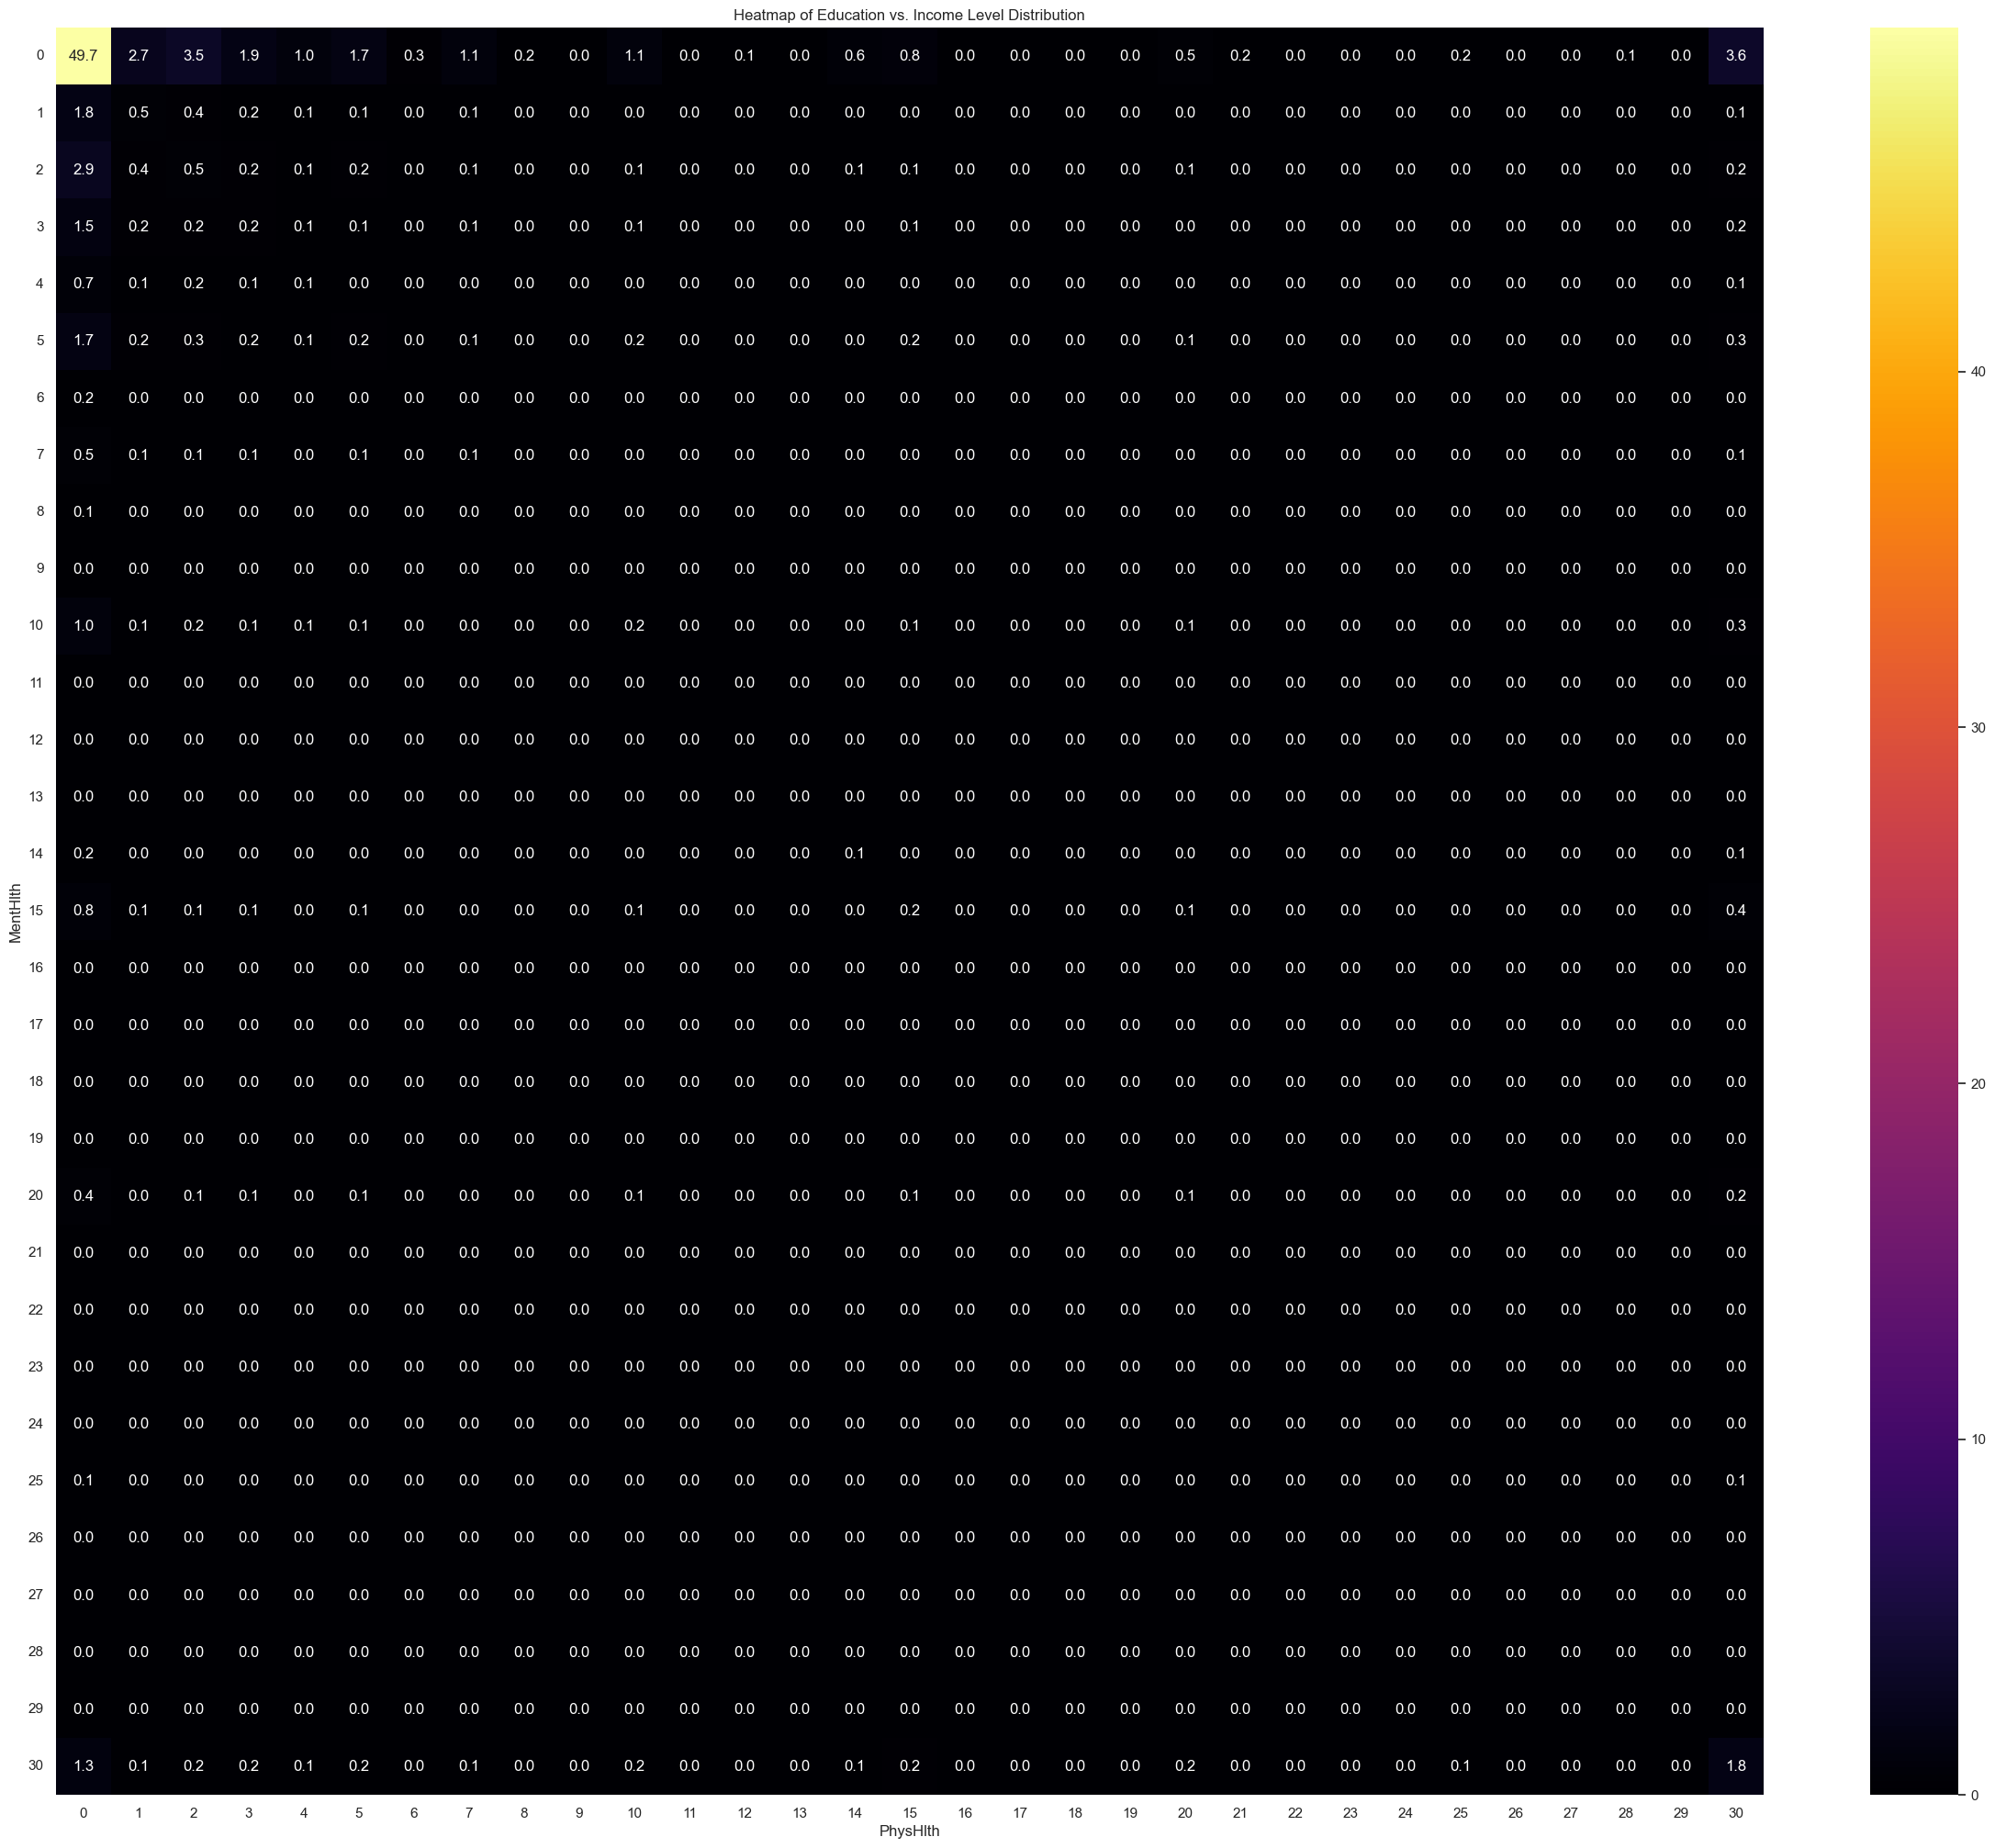

In [36]:
combined_data['MentHlth'] = data['MentHlth'].astype(int)
combined_data['PhysHlth'] = data['PhysHlth'].astype(int)

pivot_table = pd.crosstab(combined_data['MentHlth'], combined_data['PhysHlth'], normalize='all') * 100

plt.figure(figsize=(30, 25))
sns.heatmap(pivot_table, annot=True, cmap='inferno', fmt='.1f')
plt.title('Heatmap of Education vs. Income Level Distribution')

plt.yticks(rotation=0) 
plt.show()

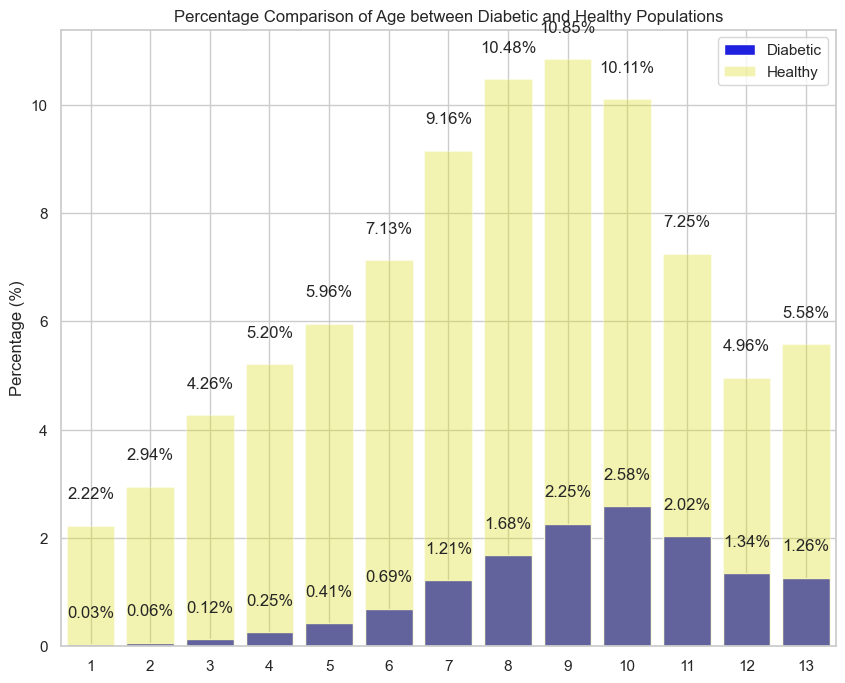

In [37]:
labels = [str(i) for i in list(range(1, 14))]
values = list(range(1, 14))

# Count the occurrences of each income level normalized and scaled by the relative sizes
income_counts_d = diabetic['Age'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['Age'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(10, 8))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

# Adding percentage annotations on each bar
for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage Comparison of Age between Diabetic and Healthy Populations')

plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

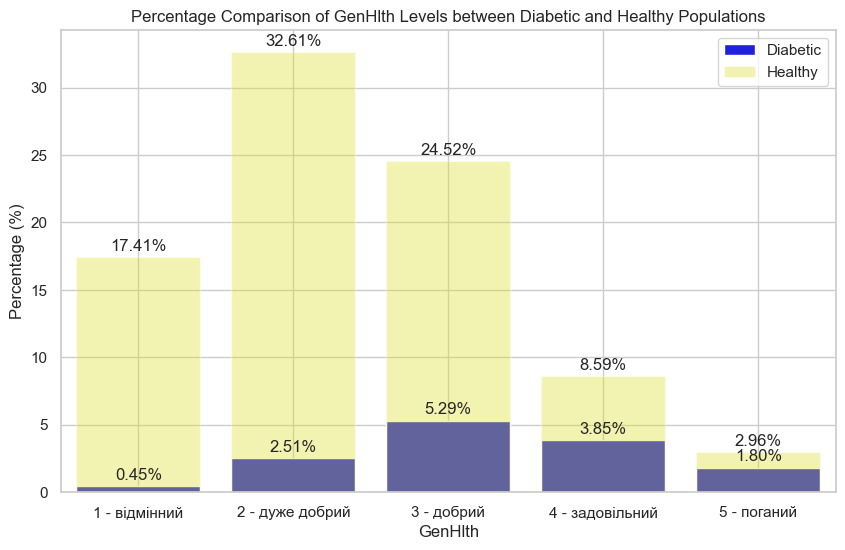

In [39]:
labels = ['1 - відмінний', '2 - дуже добрий', '3 - добрий', '4 - задовільний', '5 - поганий']
values = [1, 2, 3, 4, 5]

income_counts_d = diabetic['GenHlth'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['GenHlth'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(10, 6))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage Comparison of GenHlth Levels between Diabetic and Healthy Populations')
plt.xlabel('GenHlth')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


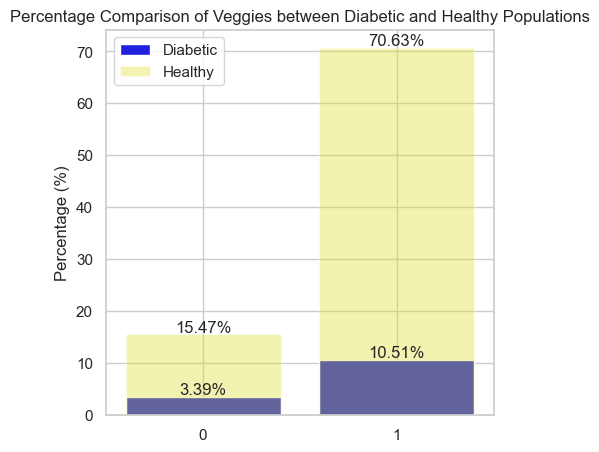

In [40]:
labels = ['0', '1']
values = (0,1)

income_counts_d = diabetic['Veggies'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['Veggies'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(5, 5))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage Comparison of Veggies between Diabetic and Healthy Populations')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


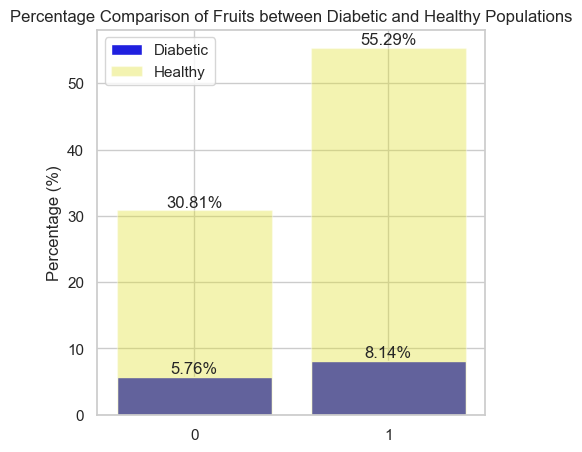

In [41]:
labels = ['0', '1']  
values = (0,1)

income_counts_d = diabetic['Fruits'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['Fruits'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(5, 5))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage Comparison of Fruits between Diabetic and Healthy Populations')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


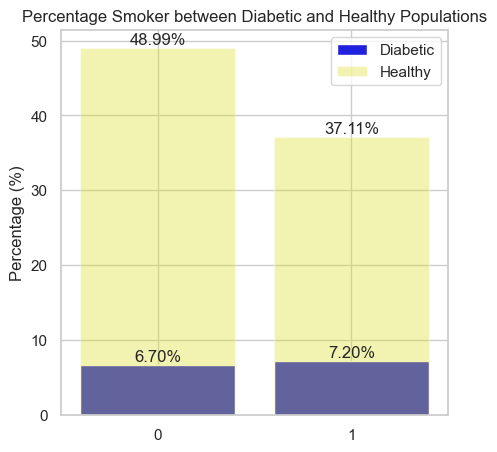

In [42]:
labels = ['0', '1'] 
values = (0,1)

income_counts_d = diabetic['Smoker'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['Smoker'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(5, 5))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage Smoker between Diabetic and Healthy Populations')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


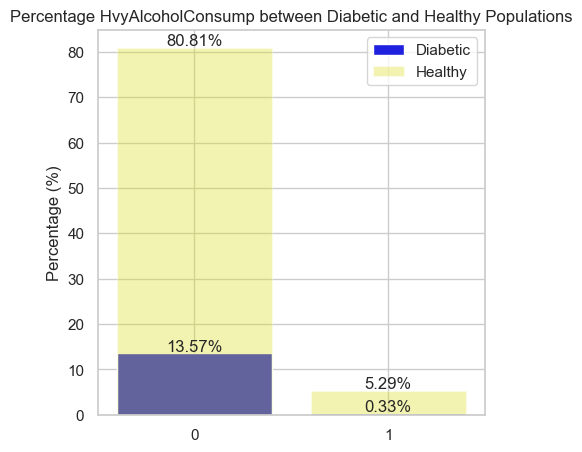

In [43]:
labels = ['0', '1']  
values = (0,1)

income_counts_d = diabetic['HvyAlcoholConsump'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['HvyAlcoholConsump'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(5, 5))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage HvyAlcoholConsump between Diabetic and Healthy Populations')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


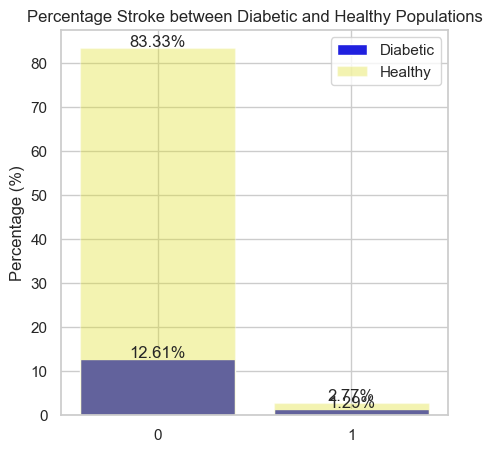

In [44]:

# Labels and values for Income levels
labels = ['0', '1']  # Convert each number to string for labels
values = (0,1)


# Count the occurrences of each income level normalized and scaled by the relative sizes
income_counts_d = diabetic['Stroke'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['Stroke'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(5, 5))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

# Adding percentage annotations on each bar
for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage Stroke between Diabetic and Healthy Populations')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


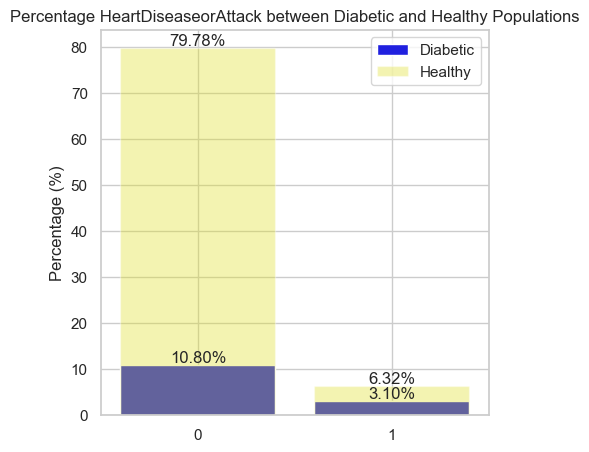

In [45]:

# Labels and values for Income levels
labels = ['0', '1']  # Convert each number to string for labels
values = (0,1)


# Count the occurrences of each income level normalized and scaled by the relative sizes
income_counts_d = diabetic['HeartDiseaseorAttack'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['HeartDiseaseorAttack'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(5, 5))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

# Adding percentage annotations on each bar
for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage HeartDiseaseorAttack between Diabetic and Healthy Populations')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


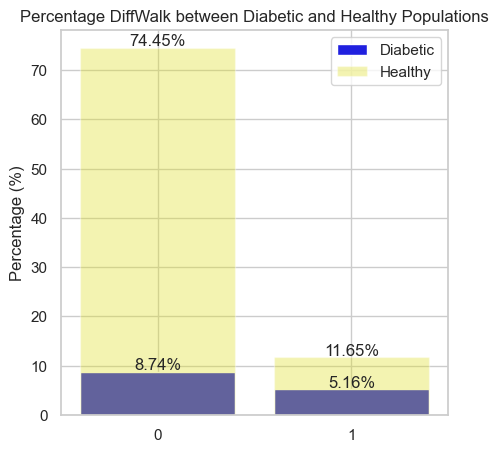

In [46]:
labels = ['0', '1'] 
values = (0,1)

income_counts_d = diabetic['DiffWalk'].value_counts(normalize=True).reindex(values) * 13.9
income_counts_h = healthy['DiffWalk'].value_counts(normalize=True).reindex(values) * 86.1

plt.figure(figsize=(5, 5))
bar1 = sns.barplot(x=labels, y=income_counts_d.values, color='blue', alpha=1, label='Diabetic')
bar2 = sns.barplot(x=labels, y=income_counts_h.values, color='yellow', alpha=0.35, label='Healthy')

for p in bar1.patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width() / 2., height + 0.5, '{:1.2f}%'.format(height), ha="center")


plt.title('Percentage DiffWalk between Diabetic and Healthy Populations')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
data.duplicated().sum()

46894

In [48]:
data = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

In [49]:
df_features = data.drop("Diabetes_binary",axis=1)
df_target = data["Diabetes_binary"]

In [50]:
nm = NearMiss(version = 1 , n_neighbors = 10)
df_features, df_target = nm.fit_resample(df_features, df_target)

In [51]:
data.drop_duplicates(inplace = True)

In [52]:
threshold = 10

In [53]:
high_score_features_mic = []
feature_scores = mutual_info_classif(df_features, df_target, random_state=0)
for score, f_name in sorted(zip(feature_scores, df_features.columns), reverse=True)[:threshold]:
        high_score_features_mic.append(f_name)
high_score_features_mic

['GenHlth',
 'PhysHlth',
 'Income',
 'DiffWalk',
 'MentHlth',
 'BMI',
 'Education',
 'PhysActivity',
 'HighBP',
 'Veggies']

In [54]:
skb = SelectKBest(score_func=chi2, k=threshold)
sel_skb = skb.fit(df_features, df_target)
sel_skb_index = sel_skb.get_support()
df_norm_skb = df_features.iloc[:, sel_skb_index]
high_score_features_skb = list(df_norm_skb.columns)
high_score_features_skb

['HighBP',
 'BMI',
 'Stroke',
 'HeartDiseaseorAttack',
 'NoDocbcCost',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'DiffWalk',
 'Income']

In [55]:
pearson_list = []
for i in list(df_features.columns):
    p,_ = pearsonr(df_features[i], df_target)
    pearson_list.append(abs(p))
    
p_value=pd.Series(pearson_list,index=df_features.columns)
p_value.sort_values(ascending=False,inplace=True)
high_score_features_pearson = list(p_value.index[:threshold])
high_score_features_pearson

['GenHlth',
 'Income',
 'DiffWalk',
 'PhysHlth',
 'Education',
 'PhysActivity',
 'BMI',
 'MentHlth',
 'HighBP',
 'HeartDiseaseorAttack']

In [56]:
high_score_features = []
for i in  high_score_features_mic:
    if i in high_score_features_skb and i in high_score_features_pearson:
        high_score_features.append(i)

high_score_features

['GenHlth', 'PhysHlth', 'Income', 'DiffWalk', 'MentHlth', 'BMI', 'HighBP']

In [62]:
y = df_target

features_list = [
    ["All",df_features],
#----------------------------------------------------------      
    ["Skb - 3", df_features[high_score_features_skb[:3]]],
    ["Skb - 5", df_features[high_score_features_skb[:5]]],
    ["Skb - 7", df_features[high_score_features_skb[:7]]],
    ["Skb - 10", df_features[high_score_features_skb]],
#----------------------------------------------------------      
    ["Mic - 3", df_features[high_score_features_mic[:3]]],
    ["Mic - 5", df_features[high_score_features_mic[:5]]],
    ["Mic - 7", df_features[high_score_features_mic[:7]]],
    ["Mic - 10", df_features[high_score_features_mic]],
#----------------------------------------------------------      
    ["Pearson - 3", df_features[high_score_features_pearson[:3]]],
    ["Pearson - 5", df_features[high_score_features_pearson[:5]]],
    ["Pearson - 7", df_features[high_score_features_pearson[:7]]],
    ["Pearson - 10", df_features[high_score_features_pearson]],
#----------------------------------------------------------      
    ["Best - 7", df_features[high_score_features]],
#----------------------------------------------------------    
    ["Choose - 3", df_features[['BMI','Age','HighBP']]],
    ["Choose - 5", df_features[['BMI','Age','HighBP','MentHlth','Smoker']]],
    ["Choose - 7", df_features[['BMI','Age','HighBP','MentHlth','Smoker','GenHlth','PhysHlth']]], 
]


In [63]:
scalar = StandardScaler()
data = []
evaluations = pd.DataFrame()

for name, X in features_list:
    data.append([name, scalar.fit_transform(X)])

In [64]:
splited_data = []
for name, X in data:
    X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.3)
    splited_data.append({
            'name': name ,'X_train': X_train,
            'X_test':X_test,'y_train':y_train,
            'y_test':y_test
        })

In [65]:
data = splited_data[0]
pred_model_list = []
for data in tqdm(splited_data):
    fs = data["name"]
    models =[
        ['LR', LogisticRegression(), data],
        ['RF', RandomForestClassifier(max_depth=5,n_estimators=1000, class_weight='balanced'), data],
        ['DT', DecisionTreeClassifier(max_depth=5), data],
        ['KNN', KNeighborsClassifier(n_neighbors= 6), data],
        ['SVM', SVC(probability=True), data]
    ]

    roc_model_list = []
    accuracy_model_list = []
    f1_model_list = []
    recall_model_list = []
    precision_model_list = []

    for name ,model, data in tqdm(models):
        X_train, X_test, y_train, y_test= data['X_train'], data['X_test'], data['y_train'], data['y_test']
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:,1]
        
        pred_model_list.append({
            "model": name,
            "fs": fs,
            "data": y_pred
        })
        
        roc_model_list.append(metrics.roc_auc_score(y_test,y_pred))
        
        y_pred = [0 if (y<0.5)else 1 for y in y_pred]
                
        accuracy_model_list.append(metrics.accuracy_score(y_test,y_pred))
        f1_model_list.append(metrics.f1_score(y_test,y_pred))
        recall_model_list.append(metrics.recall_score(y_test,y_pred))
        precision_model_list.append(metrics.precision_score(y_test,y_pred))
        
    names = [name for name ,_ ,_ in models]
    fsm = [data['name'] for _ ,_ ,data in models]
    evaluation = pd.DataFrame({'classifiers': names,'Feature selection method': fsm ,'AUC Score': roc_model_list, 'Accuracy':accuracy_model_list,'Precision':precision_model_list,'Recall':recall_model_list, 'F-measure':f1_model_list})

    evaluations = pd.concat([evaluations, evaluation], ignore_index=True)
    
    evaluation = evaluation.sort_values(by='AUC Score', ascending=False)
    print(evaluation)

  6%|████▋                                                                           | 1/17 [08:07<2:09:59, 487.44s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
4         SVM                      All   0.951643  0.900556   0.946844   
0          LR                      All   0.943192  0.880234   0.921642   
1          RF                      All   0.942746  0.874198   0.938940   
2          DT                      All   0.910983  0.844493   0.967614   
3         KNN                      All   0.908618  0.844917   0.886201   

     Recall  F-measure  
4  0.849337   0.895444  
0  0.831844   0.874444  
1  0.801185   0.864610  
2  0.713721   0.821498  
3  0.792439   0.836701  



 12%|█████████▍                                                                      | 2/17 [19:08<2:27:25, 589.71s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF                  Skb - 3   0.785560  0.701198   0.800218   
2          DT                  Skb - 3   0.779069  0.703178   0.723666   
0          LR                  Skb - 3   0.766500  0.695209   0.721147   
4         SVM                  Skb - 3   0.763782  0.706479   0.746503   
3         KNN                  Skb - 3   0.751351  0.683374   0.684326   

     Recall  F-measure  
1  0.546149   0.649211  
2  0.669274   0.695408  
0  0.648878   0.683106  
4  0.636304   0.687013  
3  0.695353   0.689795  



 18%|██████████████                                                                  | 3/17 [29:01<2:17:56, 591.18s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF                  Skb - 5   0.823682  0.741465   0.838151   
0          LR                  Skb - 5   0.810931  0.739721   0.783134   
2          DT                  Skb - 5   0.807697  0.737363   0.828678   
4         SVM                  Skb - 5   0.803353  0.747831   0.800835   
3         KNN                  Skb - 5   0.762521  0.695209   0.689178   

     Recall  F-measure  
1  0.602885   0.701313  
0  0.667978   0.720987  
2  0.602978   0.698038  
4  0.664325   0.726221  
3  0.718741   0.703649  



 24%|██████████████████▊                                                             | 4/17 [36:11<1:54:16, 527.40s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF                  Skb - 7   0.904617  0.822944   0.894966   
0          LR                  Skb - 7   0.894462  0.814080   0.842641   
2          DT                  Skb - 7   0.890906  0.811439   0.911182   
4         SVM                  Skb - 7   0.886712  0.823038   0.897515   
3         KNN                  Skb - 7   0.875359  0.792814   0.795086   

     Recall  F-measure  
1  0.726674   0.802087  
0  0.766593   0.802820  
2  0.684844   0.781964  
4  0.724286   0.801649  
3  0.781874   0.788424  



 29%|███████████████████████▌                                                        | 5/17 [41:21<1:29:48, 449.04s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF                 Skb - 10   0.937499  0.866135   0.942822   
0          LR                 Skb - 10   0.935327  0.866890   0.920764   
4         SVM                 Skb - 10   0.928022  0.873963   0.948562   
3         KNN                 Skb - 10   0.919635  0.857554   0.879571   
2          DT                 Skb - 10   0.909498  0.843974   0.959730   

     Recall  F-measure  
1  0.781071   0.854358  
0  0.804427   0.858673  
4  0.792233   0.863378  
3  0.830316   0.854234  
2  0.719820   0.822640  



 35%|████████████████████████████▏                                                   | 6/17 [46:17<1:12:48, 397.18s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF                  Mic - 3   0.908472  0.832940   0.917776   
2          DT                  Mic - 3   0.905364  0.827707   0.929081   
0          LR                  Mic - 3   0.903573  0.830819   0.883878   
4         SVM                  Mic - 3   0.893460  0.830913   0.889761   
3         KNN                  Mic - 3   0.881181  0.752122   0.706456   

     Recall  F-measure  
1  0.732512   0.814745  
2  0.710700   0.805348  
0  0.762881   0.818934  
4  0.756581   0.817785  
3  0.865269   0.777839  



 41%|█████████████████████████████████▊                                                | 7/17 [50:57<59:47, 358.72s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF                  Mic - 5   0.923474  0.858072   0.924522   
0          LR                  Mic - 5   0.920825  0.854300   0.925473   
4         SVM                  Mic - 5   0.915265  0.857884   0.934004   
2          DT                  Mic - 5   0.911949  0.842229   0.898605   
3         KNN                  Mic - 5   0.907910  0.847605   0.889382   

     Recall  F-measure  
1  0.779779   0.846004  
0  0.770631   0.840984  
4  0.770159   0.844206  
2  0.771480   0.830204  
3  0.793926   0.838948  



 47%|██████████████████████████████████████▌                                           | 8/17 [55:55<50:54, 339.39s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF                  Mic - 7   0.934767  0.864391   0.940749   
0          LR                  Mic - 7   0.931167  0.860713   0.912889   
4         SVM                  Mic - 7   0.919937  0.870992   0.953014   
3         KNN                  Mic - 7   0.913894  0.852461   0.877348   
2          DT                  Mic - 7   0.908474  0.842889   0.956533   

     Recall  F-measure  
1  0.778801   0.852149  
0  0.798628   0.851945  
4  0.781432   0.858736  
3  0.820710   0.848085  
2  0.719602   0.821321  



 53%|██████████████████████████████████████████▎                                     | 9/17 [1:00:44<43:09, 323.74s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
4         SVM                 Mic - 10   0.939692  0.880375   0.941054   
1          RF                 Mic - 10   0.939464  0.870143   0.940508   
0          LR                 Mic - 10   0.937163  0.867880   0.912307   
3         KNN                 Mic - 10   0.917219  0.851424   0.867332   
2          DT                 Mic - 10   0.911655  0.847652   0.935790   

     Recall  F-measure  
4  0.811201   0.871316  
1  0.789856   0.858624  
0  0.813563   0.860110  
3  0.829241   0.847859  
2  0.746033   0.830207  



 59%|██████████████████████████████████████████████▍                                | 10/17 [1:06:28<38:29, 329.89s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF              Pearson - 3   0.889986  0.803706   0.827809   
2          DT              Pearson - 3   0.889183  0.802810   0.828743   
0          LR              Pearson - 3   0.884913  0.801066   0.828834   
3         KNN              Pearson - 3   0.873067  0.782441   0.771912   
4         SVM              Pearson - 3   0.858659  0.803706   0.827809   

     Recall  F-measure  
1  0.769130   0.797391  
2  0.765562   0.795900  
0  0.761055   0.793500  
3  0.804525   0.787882  
4  0.769130   0.797391  



 65%|███████████████████████████████████████████████████                            | 11/17 [1:11:31<32:09, 321.64s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF              Pearson - 5   0.918469  0.841758   0.917457   
0          LR              Pearson - 5   0.913784  0.836807   0.886491   
2          DT              Pearson - 5   0.906318  0.830913   0.889525   
3         KNN              Pearson - 5   0.893159  0.809317   0.810768   
4         SVM              Pearson - 5   0.885360  0.843031   0.914031   

     Recall  F-measure  
1  0.752885   0.827064  
0  0.774463   0.826699  
2  0.757670   0.818320  
3  0.809551   0.810159  
4  0.759077   0.829378  



 71%|███████████████████████████████████████████████████████▊                       | 12/17 [1:16:47<26:39, 319.98s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF              Pearson - 7   0.929435  0.856988   0.917742   
0          LR              Pearson - 7   0.924381  0.851094   0.896130   
4         SVM              Pearson - 7   0.915889  0.863401   0.934339   
2          DT              Pearson - 7   0.911729  0.841428   0.923752   
3         KNN              Pearson - 7   0.909291  0.841475   0.854252   

     Recall  F-measure  
1  0.784449   0.845876  
0  0.794439   0.842226  
4  0.781904   0.851352  
2  0.744486   0.824487  
3  0.823657   0.838676  



 76%|████████████████████████████████████████████████████████████▍                  | 13/17 [1:21:44<20:52, 313.09s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
4         SVM             Pearson - 10   0.940696  0.883016   0.944640   
1          RF             Pearson - 10   0.940664  0.872171   0.942999   
0          LR             Pearson - 10   0.939572  0.871747   0.913540   
3         KNN             Pearson - 10   0.915238  0.853310   0.874471   
2          DT             Pearson - 10   0.911128  0.851943   0.926604   

     Recall  F-measure  
4  0.812328   0.873502  
1  0.790706   0.860164  
0  0.819630   0.864041  
3  0.823139   0.848029  
2  0.762636   0.836663  



 82%|█████████████████████████████████████████████████████████████████              | 14/17 [1:26:51<15:33, 311.25s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF                 Best - 7   0.934282  0.864391   0.921458   
0          LR                 Best - 7   0.931128  0.860336   0.909150   
4         SVM                 Best - 7   0.921539  0.870426   0.944978   
3         KNN                 Best - 7   0.910976  0.844728   0.855109   
2          DT                 Best - 7   0.909030  0.844870   0.959497   

     Recall  F-measure  
1  0.794548   0.853310  
0  0.798442   0.850207  
4  0.784669   0.857395  
3  0.827413   0.841033  
2  0.717800   0.821235  



 88%|█████████████████████████████████████████████████████████████████████▋         | 15/17 [1:36:39<13:09, 394.57s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF               Choose - 3   0.786588  0.698934   0.702925   
4         SVM               Choose - 3   0.776921  0.701056   0.716005   
2          DT               Choose - 3   0.776307  0.695304   0.698026   
0          LR               Choose - 3   0.750670  0.675264   0.678440   
3         KNN               Choose - 3   0.746901  0.676962   0.656156   

     Recall  F-measure  
1  0.686241   0.694483  
4  0.663735   0.688880  
2  0.685485   0.691698  
0  0.662979   0.670620  
3  0.739858   0.695498  



 94%|██████████████████████████████████████████████████████████████████████████▎    | 16/17 [1:44:34<06:58, 418.75s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF               Choose - 5   0.853067  0.762637   0.856243   
4         SVM               Choose - 5   0.847753  0.767729   0.835487   
2          DT               Choose - 5   0.838675  0.752829   0.847607   
0          LR               Choose - 5   0.834820  0.748774   0.793753   
3         KNN               Choose - 5   0.822506  0.734110   0.734971   

     Recall  F-measure  
1  0.635794   0.729733  
4  0.671344   0.744476  
2  0.621293   0.717016  
0  0.677612   0.731099  
3  0.738890   0.736926  



100%|███████████████████████████████████████████████████████████████████████████████| 17/17 [1:50:15<00:00, 389.15s/it]

  classifiers Feature selection method  AUC Score  Accuracy  Precision  \
1          RF               Choose - 7   0.922348  0.847510   0.944888   
4         SVM               Choose - 7   0.914879  0.851047   0.938037   
0          LR               Choose - 7   0.913524  0.837608   0.888358   
2          DT               Choose - 7   0.907718  0.841051   0.950044   
3         KNN               Choose - 7   0.895972  0.821765   0.834643   

     Recall  F-measure  
1  0.737826   0.828617  
4  0.751510   0.834477  
0  0.771989   0.826096  
2  0.719706   0.818987  
3  0.802190   0.818094  


In [70]:
evaluations = evaluations.sort_values(by='AUC Score', ascending=False, ignore_index=True)
evaluations

,classifiers,Feature selection method,AUC Score,Accuracy,Precision,Recall,F-measure
0,SVM,All,0.951643,0.900556,0.946844,0.849337,0.895444
1,LR,All,0.943192,0.880234,0.921642,0.831844,0.874444
2,RF,All,0.942746,0.874198,0.938940,0.801185,0.864610
3,SVM,Pearson - 10,0.940696,0.883016,0.944640,0.812328,0.873502
4,RF,Pearson - 10,0.940664,0.872171,0.942999,0.790706,0.860164
5,SVM,Mic - 10,0.939692,0.880375,0.941054,0.811201,0.871316
6,LR,Pearson - 10,0.939572,0.871747,0.913540,0.819630,0.864041
7,RF,Mic - 10,0.939464,0.870143,0.940508,0.789856,0.858624
8,RF,Skb - 10,0.937499,0.866135,0.942822,0.781071,0.854358
9,LR,Mic - 10,0.937163,0.867880,0.912307,0.813563,0.860110


In [67]:
high_score_features_pearson

['GenHlth',
 'Income',
 'DiffWalk',
 'PhysHlth',
 'Education',
 'PhysActivity',
 'BMI',
 'MentHlth',
 'HighBP',
 'HeartDiseaseorAttack']

In [71]:
rf_classifier = RandomForestClassifier(max_depth=5, n_estimators=1000, class_weight='balanced')
numeric_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

data_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, list(range(len(high_score_features_pearson)))),
    ])

pipeline_model = Pipeline(steps=[
    ('preprocessor', data_transformer),
    ('classifier', rf_classifier)
])


In [72]:
X = df_features[high_score_features_mic]
y = df_target
X_train , X_test , y_train , y_test = train_test_split(X, df_y, test_size=0.3)
model.fit(X_train, y_train)

SVC(probability=True)

In [73]:
y_pred = model.predict_proba(X_test)[:,1]
Ascore = metrics.roc_auc_score(y_test,y_pred)
Ascore

0.9386633427144097

Train:


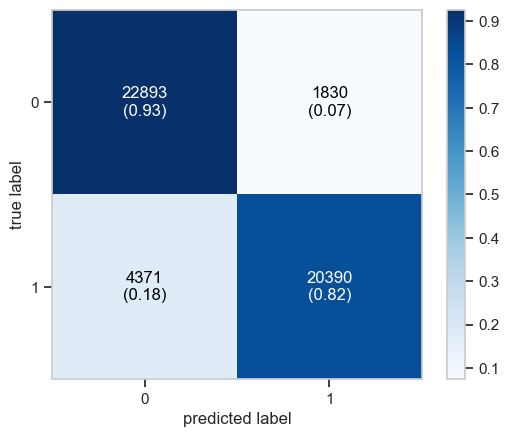

Test:


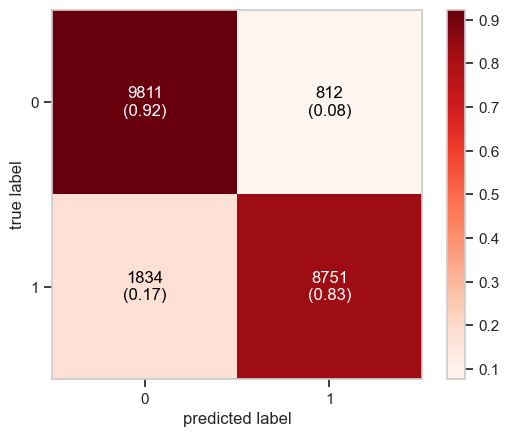

In [78]:
y_pred = [0 if (y<0.5)else 1 for y in y_pred]
print("Train:")
y_pred_trean = model.predict_proba(X_train)[:,1]
y_pred_trean = [0 if (y<0.5)else 1 for y in y_pred_trean]
cm = confusion_matrix(y_train, y_pred_trean)
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                        show_normed=True,
                        colorbar=True)
plt.show()
print("Test:")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm,show_absolute=True,
                        show_normed=True,
                        colorbar=True, cmap='Reds')
plt.show()

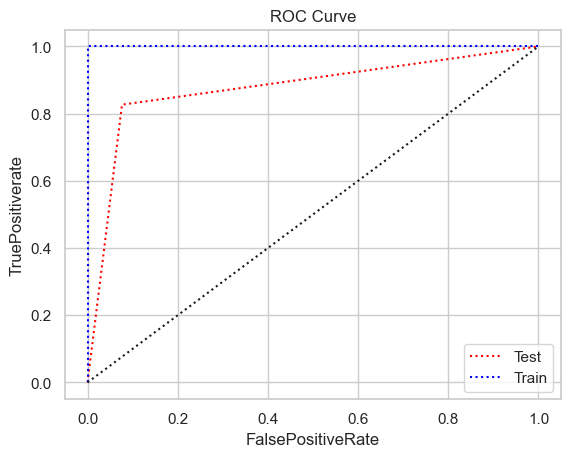

In [86]:
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_train, y_train, pos_label=1)

random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

plt.plot(fpr1, tpr1, linestyle=':',color='red', label='Test')
plt.plot(fpr2, tpr2, linestyle=':',color='blue', label='Train')
plt.plot(p_fpr, p_tpr, linestyle=':', color='k')

plt.title('ROC Curve')
plt.xlabel('FalsePositiveRate')
plt.ylabel('TruePositiverate')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [88]:
initial_type = [('input', FloatTensorType([None, 10]))]
onx = convert_sklearn(model, initial_types=initial_type, options={'zipmap': False})
with open("ModelForDiabetesPrediction.onnx", "wb") as f:
    f.write(onx.SerializeToString())